In [1]:

import numpy as np
import matplotlib.pyplot as plt
import statistics as st
import os
import pickle
import glob
%matplotlib inline

In [2]:
gain = lambda Wb,R,NPE,e:Wb/(NPE*e*R)
NumofPE=lambda Wb,R,g,e:Wb/(R*g*e)
def getValues(files,skip,nFiles=-1,findex=0,single=False,prnt=False):
    theone={}
    if(single):
        values={"time":np.array([]),"voltage":np.array([])}
        with open(files[findex]) as f:
            for i in range(0,skip):
                next(f)
            lines=f.readlines()
            for line in lines:
                splitline=line.split(",")
                values["time"]=np.append(values["time"],float(splitline[0]))
                values["voltage"]=np.append(values["voltage"],float(splitline[1]))
        theone[0]=values
        f.close()
        
    else:
        count=0
        for k in files:
            values={"time":np.array([]),"voltage":np.array([])}
            with open(k) as f:
                for i in range(0,skip):
                    next(f)
                lines=f.readlines()
                for line in lines:
                    splitline=line.split(",")
                    values["time"]=np.append(values["time"],float(splitline[0]))
                    values["voltage"]=np.append(values["voltage"],float(splitline[1]))
            theone[count]=values
            count+=1
            f.close()
            if(nFiles==count): 
                print(f"Analyzing Following Files ---> {k}")
                break

    return theone

def Histogram(data,xlabel,ylabel,title,figsize=(12,8),dpi=300,bins=3):
    plt.figure(figsize=figsize,dpi=dpi)
    plt.hist(data,bins=bins)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()
    
def WriteToFile(x,y,txtfile):
    with open(txtfile,"w") as f:
        for i in range(0,len(x)):
            s=str(x[i]) + " " +str(y[i]) +"\n"
            f.write(s)

def getArea(pmt,xlow,xhigh,minpulse=9999,gain=0,p=True):
 
    ### This is for removing DC offset
    MaskTime=pmt["time"]<=xlow
    DataNoOffset=pmt["voltage"]-st.mean(pmt["voltage"][MaskTime])
    datamin=np.min(DataNoOffset)
    if(datamin>=minpulse and minpulse!=9999): return -1
    
    if(p):
        plt.figure(figsize=(12,8),dpi=300)
        plt.plot(pmt["time"],DataNoOffset,label="Signal DC-removed")
        plt.plot(pmt["time"],pmt["voltage"],label="Signal")
        plt.axvline(xlow)
        plt.axvline(xhigh)
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage (V)")
        plt.legend()
        plt.show()

    DataMask=np.where(np.logical_and(pmt["time"]>=xlow,pmt["time"]<=xhigh))
    x=pmt["time"][DataMask]
    y=DataNoOffset[DataMask]
    
    if(p):
        plt.figure(figsize=(12,8),dpi=300)
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage (V)")
        plt.plot(x,y)
        plt.show()

    dt=pmt["time"][DataMask][1:]-pmt["time"][DataMask][:-1]
    area=abs(np.trapz(DataNoOffset[DataMask],dx=dt))
    if(gain):
        PE=NumofPE(area,50,gain,1.62e-19)
        
    
    return area,PE

def MultiAreaPE(data,xlow,xhigh,minpulse,g,p=False):
    area=np.array([])
    PE=np.array([])
    for key in data:
        result=getArea(data[key],xlow,xhigh,minpulse=minpulse,gain=g,p=p)
        if(result!=-1):
            area=np.append(area,result[0])
            PE=np.append(PE,result[1])
    values=np.array([area,PE])
    
    return values
def ListofFiles(path):
    Ch1filelist=[]
    Ch2filelist=[]
    for root, dirs, files in os.walk(path):
        for file in files:
            #append the file name to the list
            if(file[:2]=="C2"):
                Ch2filelist.append(os.path.join(root,file))
            elif(file[:2]=="C1"):
                Ch1filelist.append(os.path.join(root,file))
    return Ch1filelist,Ch2filelist
def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data

def getSimValues(files,weight):
    values={"S1_PHOTOCATHODE":np.array([]),"S2_PHOTOCATHODE":np.array([])}
    for i in files:
        count=0
        with open(i) as f:
            next(f)
            lines=f.readlines()
            for line in lines:
                splitline=line.split(",")
                values[splitline[0]]=np.append(values[splitline[0]],round(int(splitline[1])/weight))
        f.close()
        
    return values

def getValues_extra(files,weight):
    values={}
    for i in files:
        count=0
        with open(i) as f:
            next(f)
            lines=f.readlines()
            for line in lines:
                splitline=line.split(",")
                #print(splitline)
                if(splitline[0] in values.keys()):
                    values[splitline[0]]=np.append(values[splitline[0]],round(int(splitline[1])/weight))
                else:
                    values[splitline[0]]=np.array(round(int(splitline[1])/weight))
                    
        f.close()
        
    return values

def getValuesWithSource(files,weight):
    values={}

    for i in files:
        count=0
        sources={}
        with open(i) as f:
            next(f)
            lines=f.readlines()
            for line in lines:
                splitline=line.split(",")
                if(splitline[0] in values.keys()):
                    if(splitline[1] in values[splitline[0]].keys()):
                        values[splitline[0]][splitline[1]]=np.append(values[splitline[0]][splitline[1]],round(int(splitline[2])/weight))
                    else:
                        sources[splitline[1]]=np.array(round(int(splitline[2])/weight))
                        values[splitline[0]][splitline[1]]=sources[splitline[1]]
                else:
                    sources={}
                    sources[splitline[1]]=np.array(round(int(splitline[2])/weight))
                    values[splitline[0]]=sources
        f.close()
        
    return values


### Photons

## point Source
Point_SolidAngle=lambda r,R:(r**2/(4*R**2))

## Disk Source
Disk_SolidAngle=lambda A,B:(B**2/4)*(1-3/4*(A**2+B**2)+15/8*(1/3*(A**4+B**4)+(A*B)**2)-35/16*(1/4*(A**6+B**6)+3/2*(A*B)**2*(A**2+B**2)))

        

In [3]:
### Gains ###
IlkersGains=[3.9e6,2.6e6]
NicksGains=[3.4e6,2.2e6]
#NicksGains=[4.57e6,2.2e6]
DrBrandtGains=[2.5e6,3.8e6]

In [4]:
Ch1=ListofFiles("/media/ilker/Ilker/CRAB/07.09.22/S2")[0]
Ch2=ListofFiles("/media/ilker/Ilker/CRAB/07.09.22/S2")[1]
Path="/media/ilker/Ilker/CRAB/Analysis/CRAB/Main/SimAnalysis/"

Analyzing Following Files ---> /media/ilker/Ilker/CRAB/07.09.22/S2/1/C1s200005.csv


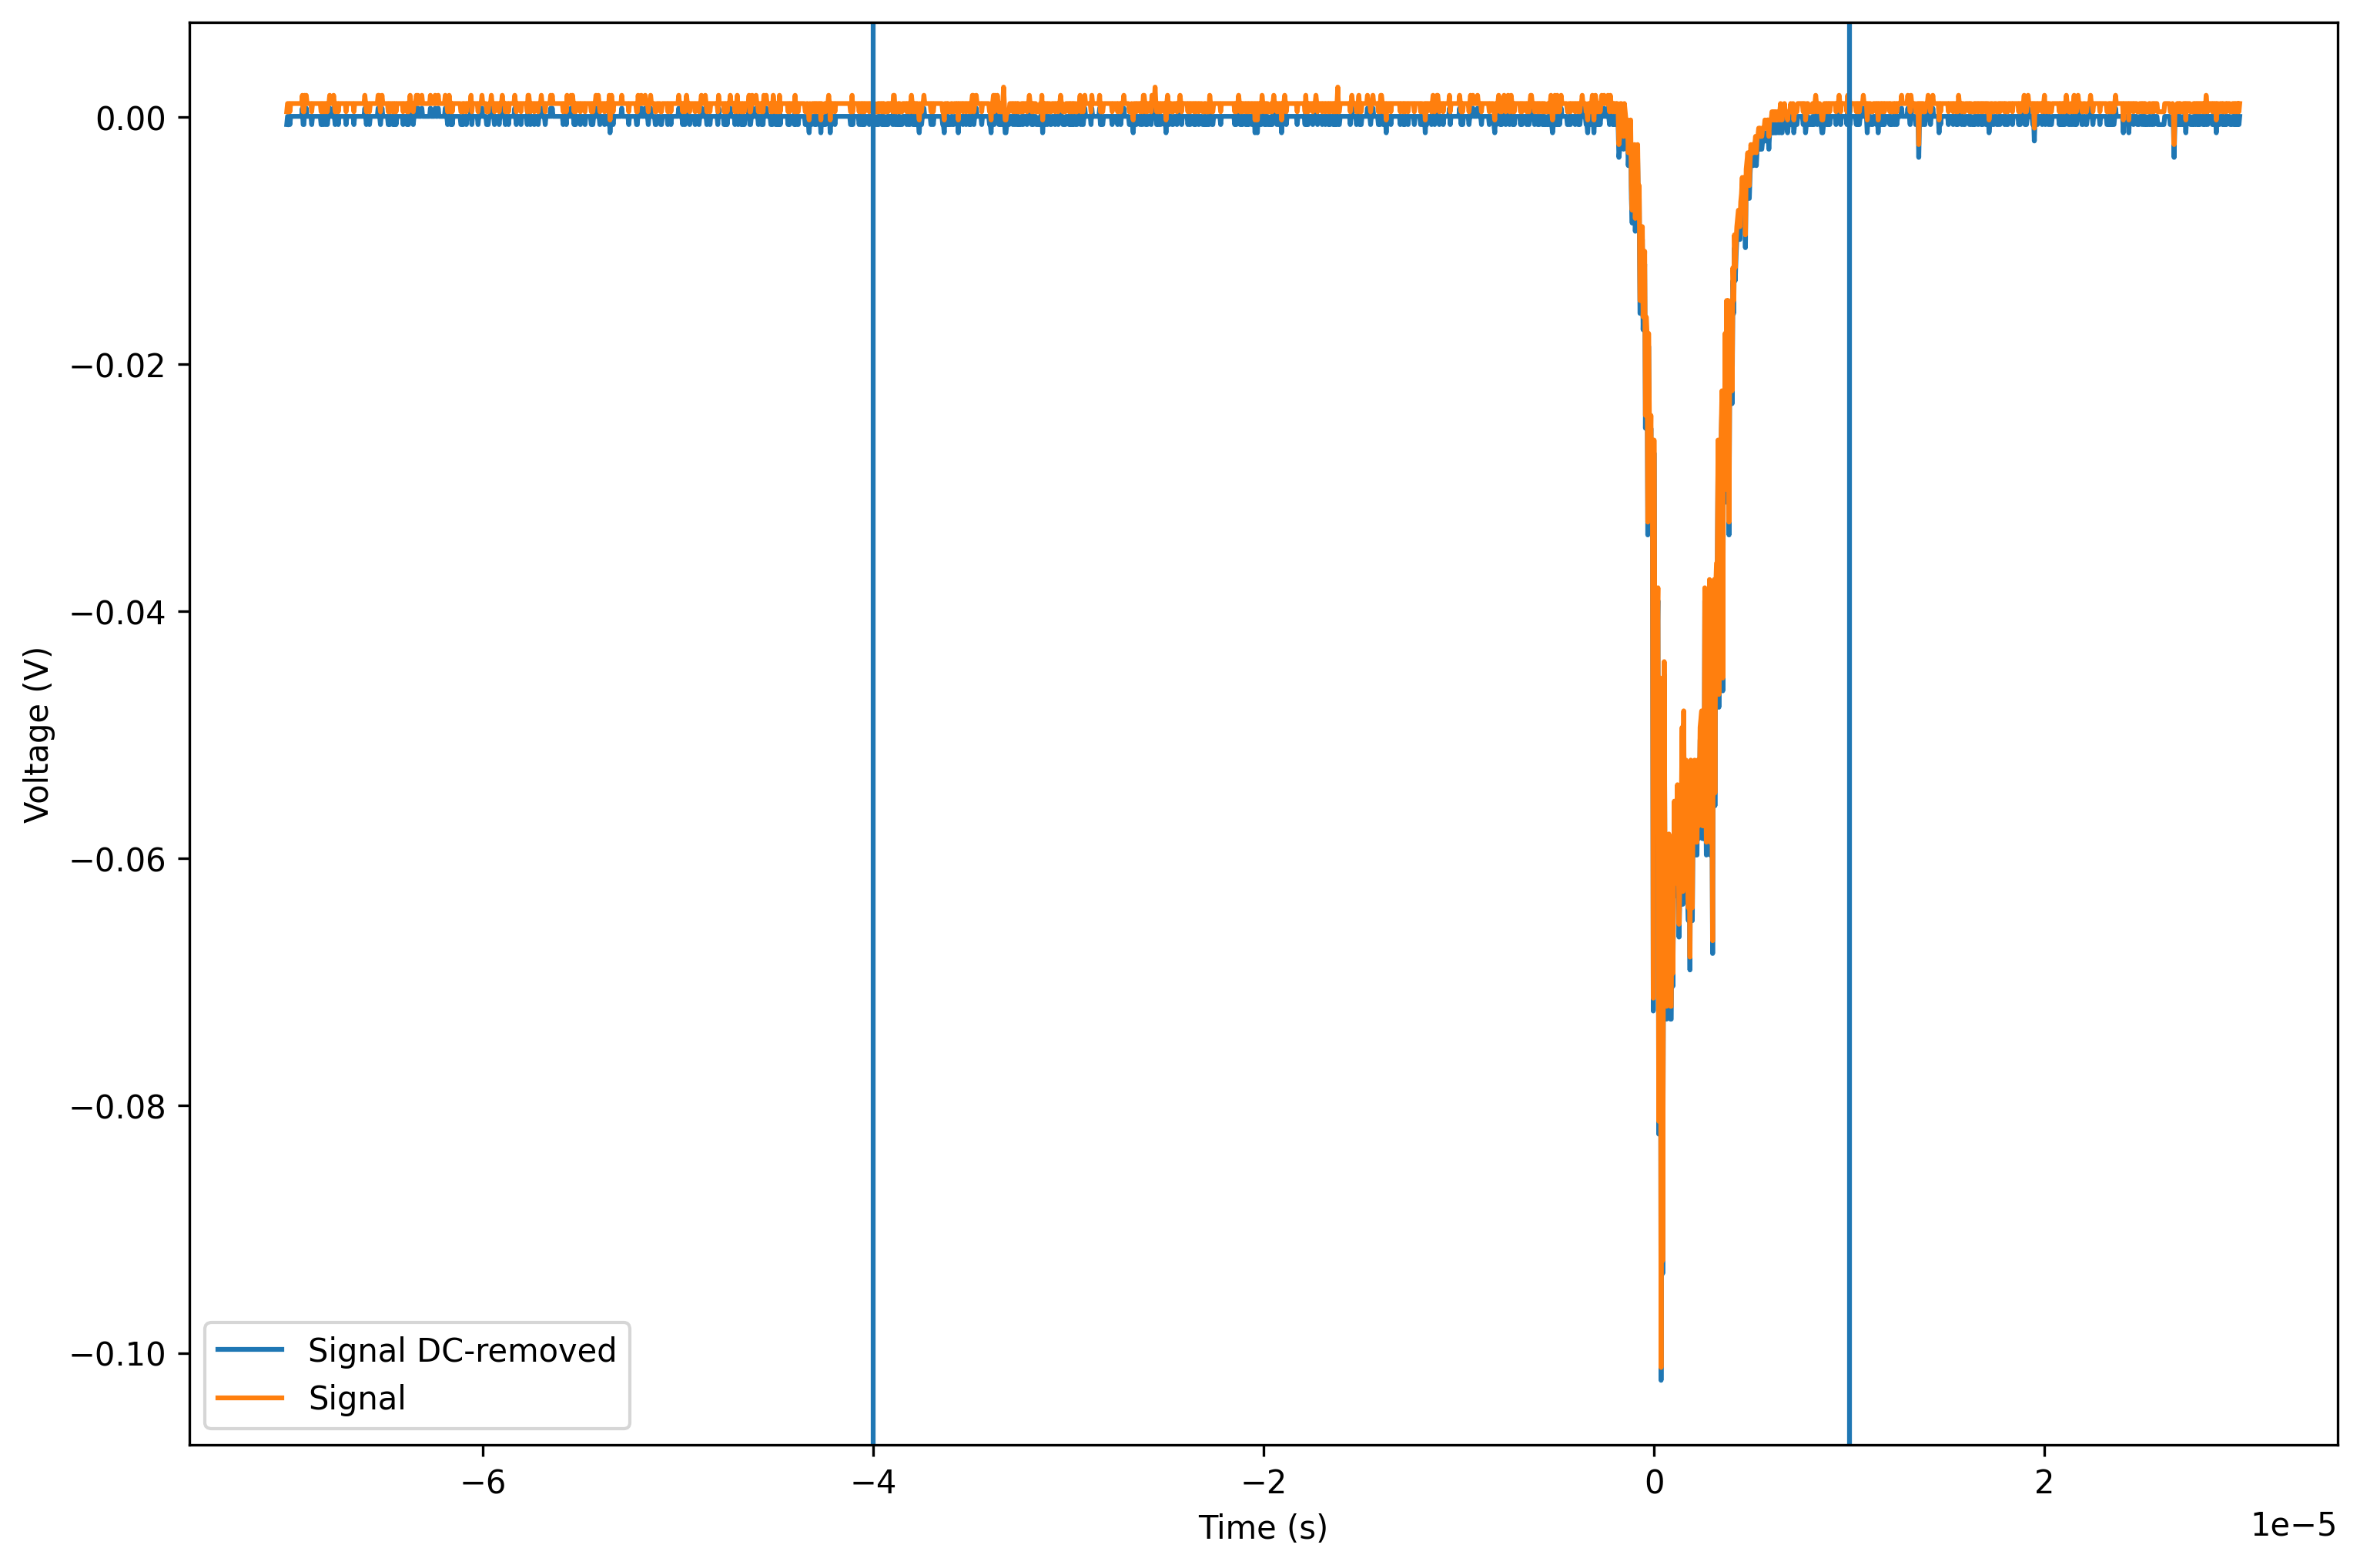

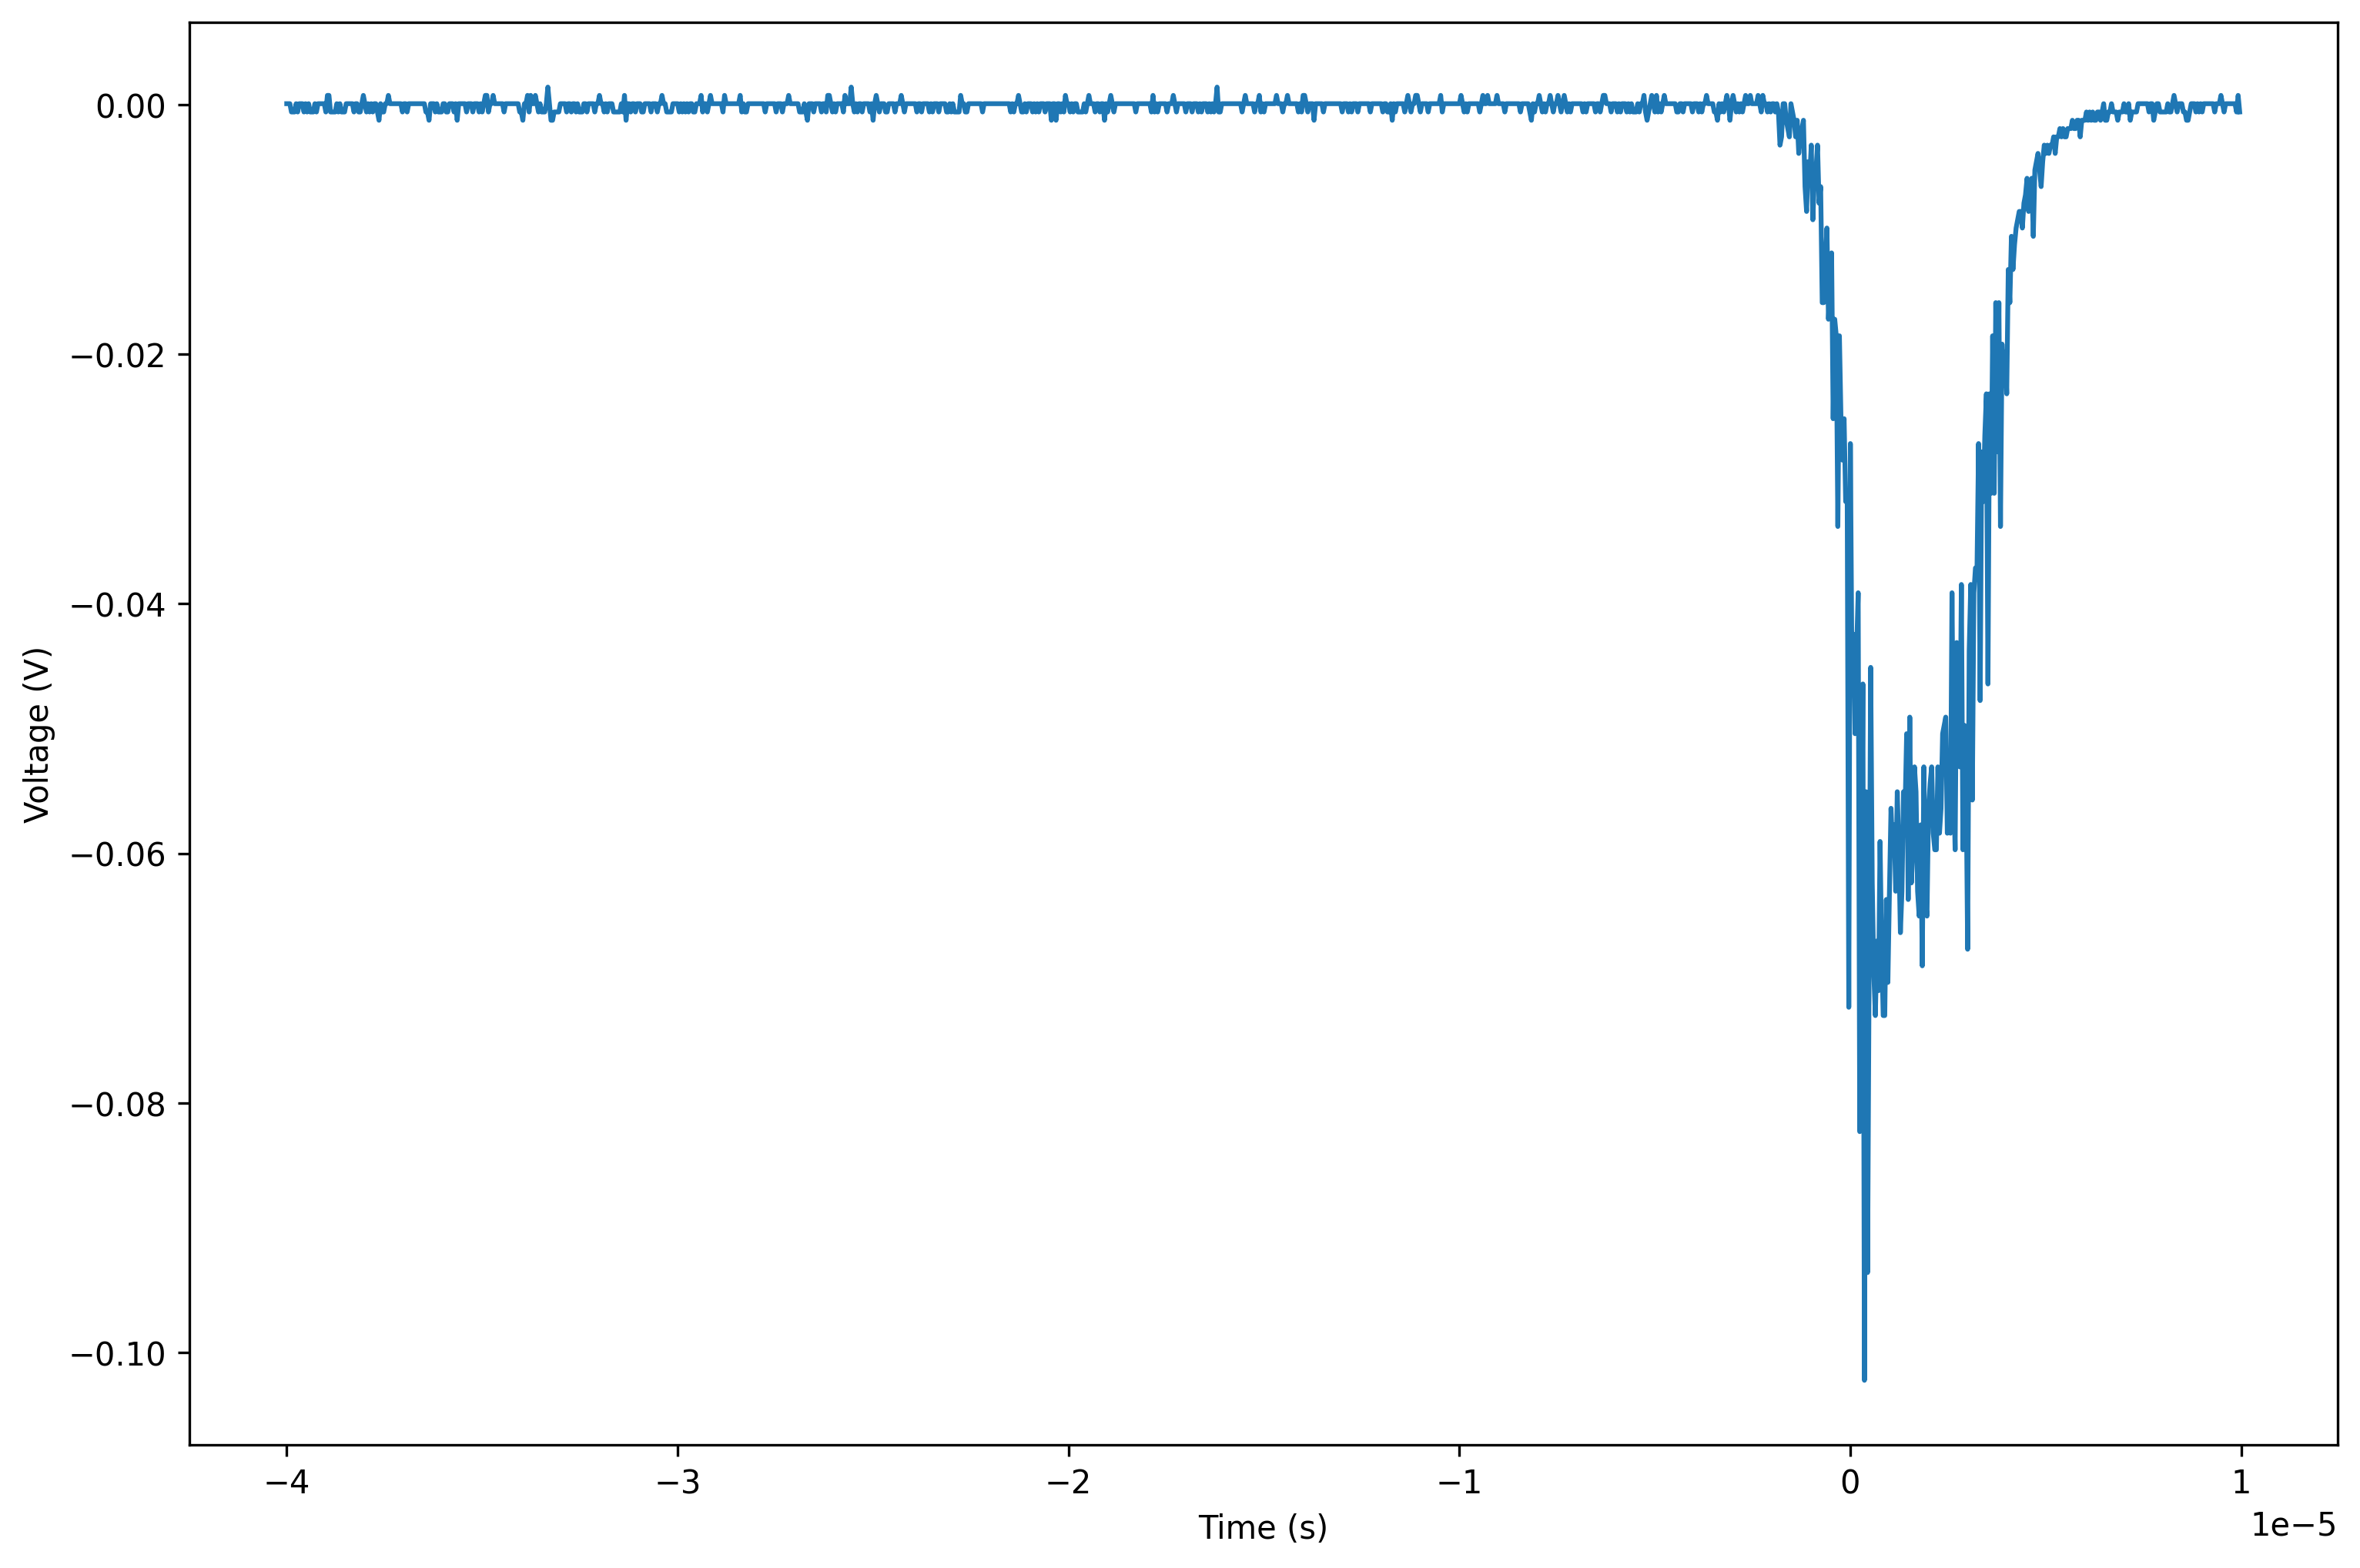

(2.438036056366804e-07, 7717.746300622994)

In [5]:
Ch1data=getValues(Ch1,5,nFiles=20,single=False,prnt=False)
getArea(Ch1data[1],-4e-5,1e-5,minpulse=-0.003,gain=IlkersGains[0],p=True)

In [6]:
##### SIM S2 ####
SimPath="/media/ilker/Ilker/CRAB/07_20_2022/S2_counts/*.txt"
S2files = glob.glob(SimPath,recursive=True)
S2=getSimValues(S2files,1)

#Histogram(S2["S1_PHOTOCATHODE"],"PhotoElectrons","# Events","PMT3_S2",bins=50)
PMT1_S2_mean=st.mean(S2["S2_PHOTOCATHODE"])
PMT1_S2_stdev=st.stdev(S2["S2_PHOTOCATHODE"])
PMT3_S1_mean=st.mean(S2["S1_PHOTOCATHODE"])


In [7]:
if(not(os.path.exists(Path+"R2_Ch1_data.p"))): 
    Ch1data=getValues(Ch1,5,single=False,prnt=False)
    PickleITDump(Ch1data,Path+"R2_Ch1_data.p")
else:
    Ch1data=PickleITRead(Path+"R2_Ch1_data.p")

if(not(os.path.exists(Path+"R2_Ch2_data.p"))):
    Ch2data=getValues(Ch2,5,single=False,prnt=False)
    PickleITDump(Ch2data,Path+"R2_Ch2_data.p")
else:
    Ch2data=PickleITRead(Path+"R2_Ch2_data.p")


In [8]:
####### SIMULATION ###############################
S1_SimPath="/media/ilker/Ilker/SimResults/Sim_Sep_14_2022/S1/counts/Photon_*.txt"
S1_InfoPath="/media/ilker/Ilker/SimResults/Sim_Sep_14_2022/S1/counts/Extra_*.txt"
S2_SimPath="/media/ilker/Ilker/SimResults/Sim_Sep_14_2022/S2/counts/Photon_*.txt"
S2_InfoPath="/media/ilker/Ilker/SimResults/Sim_Sep_14_2022/S2/counts/Extra_*.txt"

S2_SimDetailedPath="/media/ilker/Ilker/SimResults/Sim_Sep_22_2022/S2/counts/Photon_*.txt"
S2_InfoDetailedPath="/media/ilker/Ilker/SimResults/Sim_Sep_22_2022/S2/counts/Extra_*.txt"


S1_simFiles = glob.glob(S1_SimPath,recursive=True)
S1_infoFiles = glob.glob(S1_InfoPath,recursive=True)

S2_simFiles = glob.glob(S2_SimPath,recursive=True)
S2_infoFiles = glob.glob(S2_InfoPath,recursive=True)

S2_simFiles_Detailed = glob.glob(S2_SimDetailedPath,recursive=True)
S2_infoFiles_Detailed = glob.glob(S2_InfoDetailedPath,recursive=True)




S1=getValues_extra(S1_simFiles,1)
S1_info=getValues_extra(S1_infoFiles,1)

S2=getValues_extra(S2_simFiles,1)
S2_info=getValues_extra(S2_infoFiles,1)

S2_Detailed=getValuesWithSource(S2_simFiles_Detailed,1)
S2_info_Detailed=getValuesWithSource(S2_infoFiles_Detailed,1)

### S1
S1_PMT3=S1["S1_PHOTOCATHODE"]
S1_PMT1=S1["S2_PHOTOCATHODE"]
S1_PMT3_info=S1_info["S1_PHOTOCATHODE"]
S1_PMT1_info=S1_info["S2_PHOTOCATHODE"]


### S2
S2_PMT3=S2["S1_PHOTOCATHODE"]
S2_PMT1=S2["S2_PHOTOCATHODE"]
S2_PMT3_info=S2_info["S1_PHOTOCATHODE"]
S2_PMT1_info=S2_info["S2_PHOTOCATHODE"]

QE=0.130
S2_PMT1_Solid=np.round((S2_info["Total_Produced_ie"])*970*0.7*QE*Point_SolidAngle(0.5,13))
S2_PMT3_Solid=np.round(S2_info["Total_Produced_ie"]*970*0.7*QE*Point_SolidAngle(0.5,35.6))

S1_PMT1_Solid=S1_info["Total_Produced_Photons"]*QE*Point_SolidAngle(0.5,13+5.7)
S1_PMT3_Solid=S1_info["Total_Produced_Photons"]*QE*Point_SolidAngle(0.5,35.6-6)


In [9]:
binss=20

In [24]:
Ch1AreaPEIlker=MultiAreaPE(Ch1data,-4e-5,1e-5,minpulse=9999,g=IlkersGains[0],p=False)
Ch1AreaPENick=MultiAreaPE(Ch1data,-4e-5,1e-5,minpulse=9999,g=NicksGains[0],p=False)
#Ch1AreaPEDrBrantdsLab=MultiAreaPE(Ch1data,-4e-5,1e-5,minpulse=9999,g=DrBrandtGains[0],p=False)



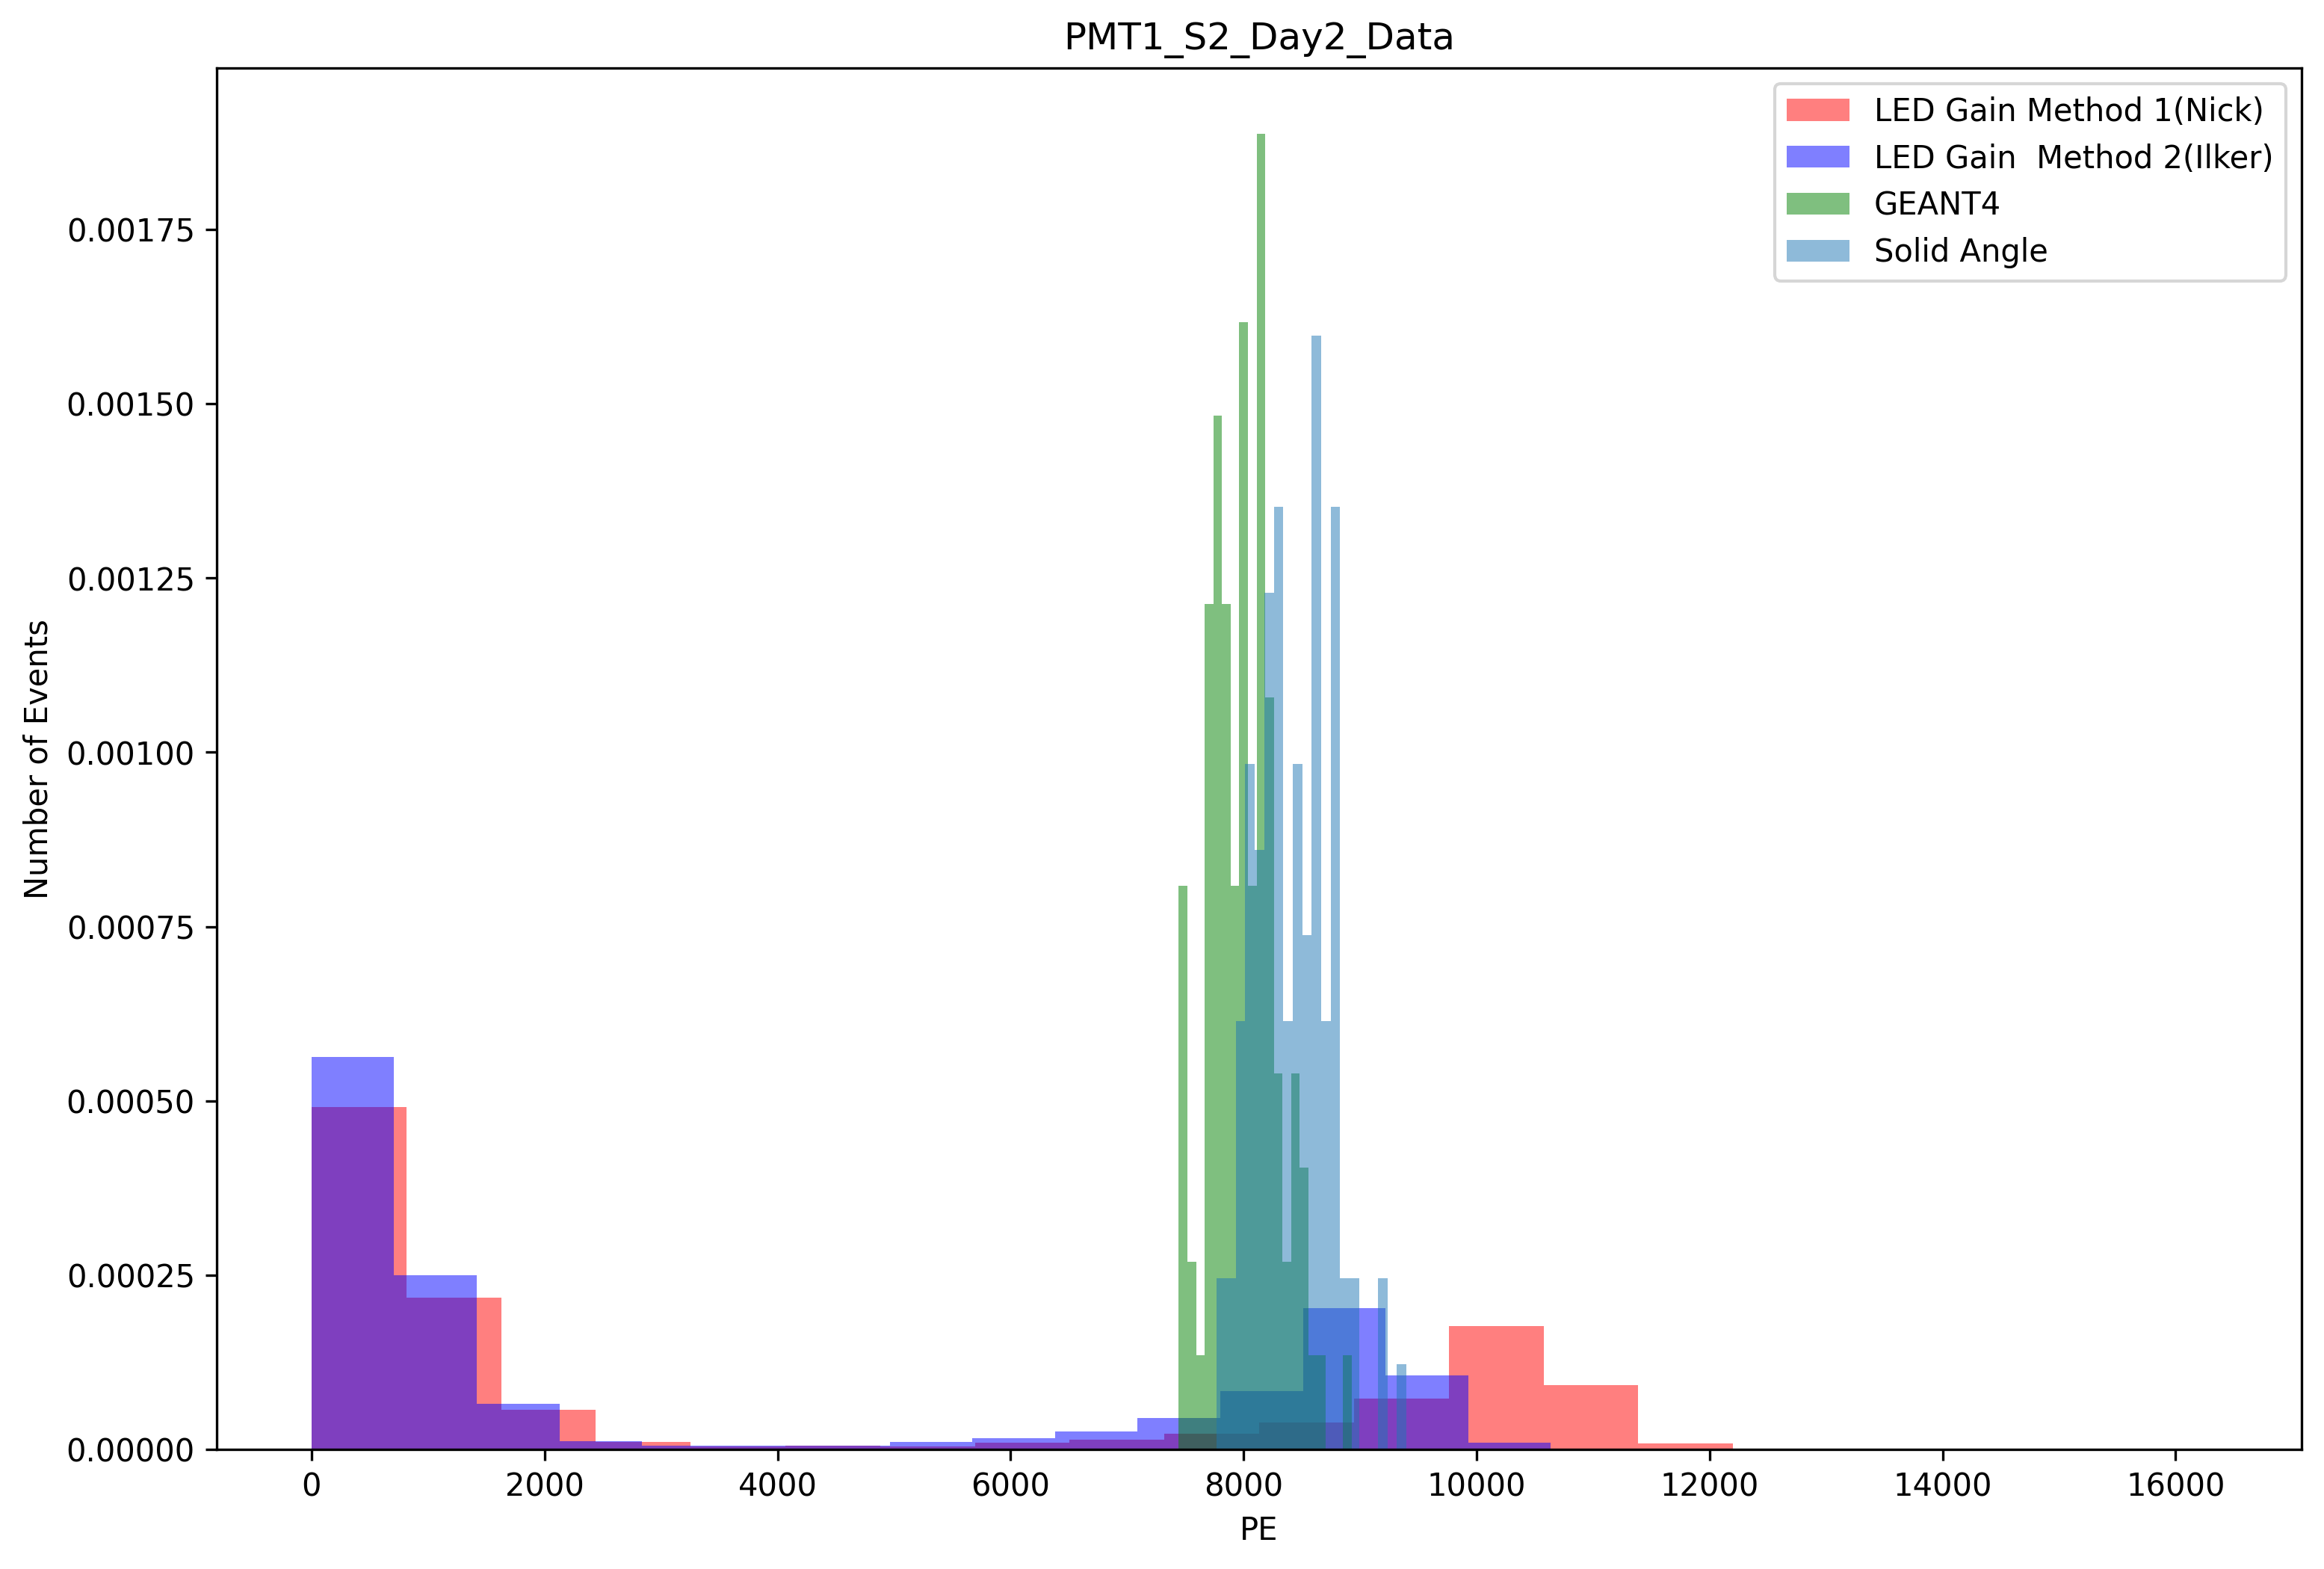

SIM PE mean = 13735.099 stdev = 531.4651921334543


In [25]:
plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT1_S2_Day2_Data")
plt.ylabel("Number of Events")
plt.xlabel("PE")
plt.hist(Ch1AreaPENick[1],bins=binss,density=True,stacked=True,label="LED Gain Method 1(Nick)",color="r",alpha=0.5)
plt.hist(Ch1AreaPEIlker[1],bins=binss,density=True,stacked=True,label="LED Gain  Method 2(Ilker)",color="b",alpha=0.5)

plt.hist(S2_PMT1,bins=binss,density=True,stacked=True,label="GEANT4",color="g",alpha=0.5)
plt.hist(S2_PMT1_Solid,bins=binss,density=True,stacked=True,label="Solid Angle",alpha=0.5)

#plt.hist(S2_Detailed["S2_PHOTOCATHODE"]["Bi210"],bins=binss ,density=True,stacked=True,label="Bi210(beta_[1.161MeV])_GEANT4",alpha=0.5)
#plt.hist(S2_Detailed["S2_PHOTOCATHODE"]["Po210"],bins=binss ,density=True,stacked=True,label="Pb210(Alpha_[5.3 MeV])_GEANT4",color="b",alpha=0.5)
#plt.hist(Ch1AreaPEIlker[1],bins=100,density=True,stacked=True,label="Ilker's Gain",color="b")

#plt.hist(Ch1AreaPEDrBrantdsLab[1],bins=binss,density=True,stacked=True,label="Gain From Dr Brandts lab",color="y")
#plt.hist(S2_Detailed["S2_PHOTOCATHODE"]["Pb210"],bins=binss ,density=True,stacked=True,label="Pb210(beta_[15keV or 61.5keV])_GEANT4",alpha=0.5)
#plt.hist(S2_Detailed["S2_PHOTOCATHODE"]["Bi210[46.539]"],bins=binss ,density=True,stacked=True,label="Bi210(gamma_[46.539keV])_GEANT4",alpha=0.5)

plt.legend()
plt.show()
#plt.semilogy()
#mean=st.mean(Ch1AreaPE[1])
#stdev=st.stdev(Ch1AreaPE[1])

#print(f"DATA PE mean = {mean} stdev = {stdev}")
print(f"SIM PE mean = {PMT1_S2_mean} stdev = {PMT1_S2_stdev}")

In [26]:
#Ch2AreaPE=MultiAreaPE(Ch2data,-4e-5,1e-5,minpulse=9999,g=Gains[1],p=False)
Ch2AreaPEIlker=MultiAreaPE(Ch2data,-4e-5,1e-5,minpulse=9999,g=IlkersGains[1],p=False)
Ch2AreaPENick=MultiAreaPE(Ch2data,-4e-5,1e-5,minpulse=9999,g=NicksGains[1],p=False)
Ch2AreaPEDrBrantdsLab=MultiAreaPE(Ch2data,-4e-5,1e-5,minpulse=9999,g=DrBrandtGains[1],p=False)

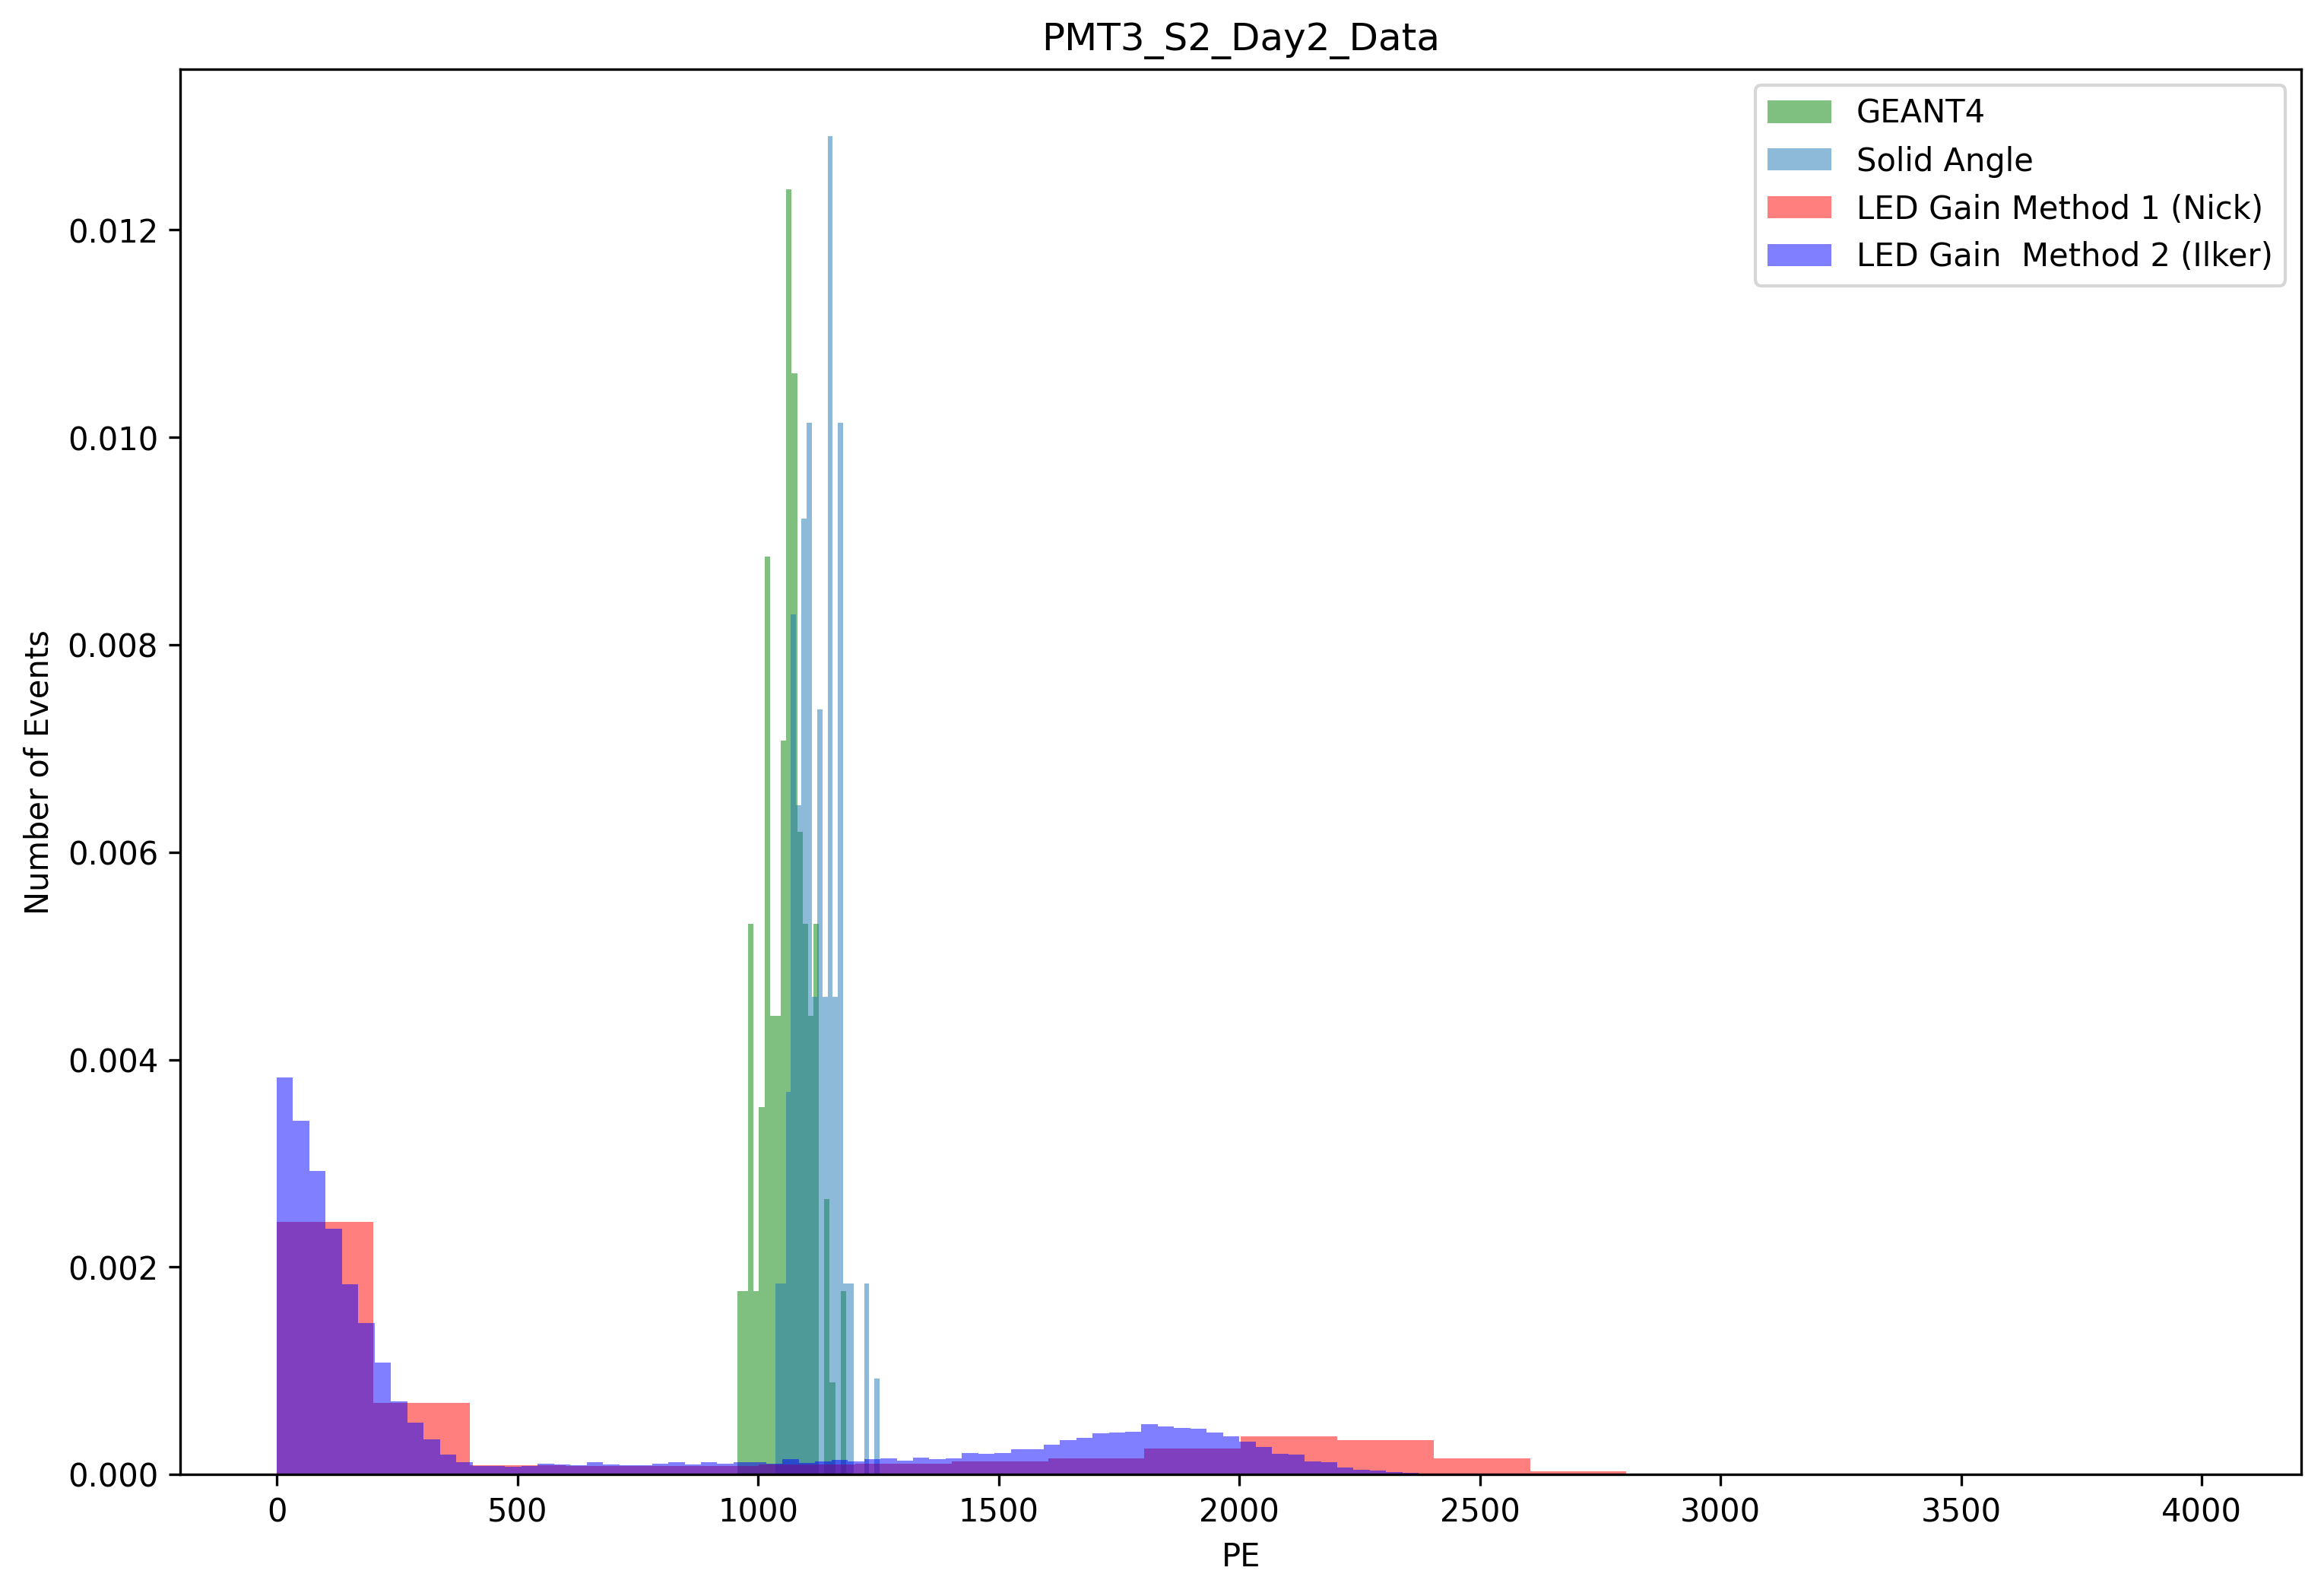

Area mean = 750.9711499322583 stdev = 885.9310665023111


In [27]:
plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT3_S2_Day2_Data")
plt.ylabel("Number of Events")
plt.xlabel("PE")
plt.hist(S2_PMT3,bins=binss,density=True,stacked=True,label="GEANT4",color="g",alpha=0.5)
plt.hist(S2_PMT3_Solid,bins=binss ,density=True,stacked=True,label="Solid Angle",alpha=0.5)
plt.hist(Ch2AreaPENick[1],bins=binss,density=True,stacked=True,label="LED Gain Method 1 (Nick)",color="r",alpha=0.5)
plt.hist(Ch2AreaPEIlker[1],bins=100,density=True,stacked=True,label="LED Gain  Method 2 (Ilker)",color="b",alpha=0.5)
#plt.hist(Ch2AreaPEDrBrantdsLab[1],bins=binss2,density=True,stacked=True,label="Gain From Dr Brandts lab",color="y")
#plt.hist(S2_Detailed["S1_PHOTOCATHODE"]["Pb210"],bins=binss ,density=True,stacked=True,label="Pb210(beta_[15keV or 61.5keV])_GEANT4",alpha=0.5)
#plt.hist(S2_Detailed["S1_PHOTOCATHODE"]["Bi210"],bins=binss ,density=True,stacked=True,label="Bi210(beta_[1.161MeV])_GEANT4",alpha=0.5)
#plt.hist(S2_Detailed["S1_PHOTOCATHODE"]["Bi210[46.539]"],bins=binss ,density=True,stacked=True,label="Bi210(gamma_[46.539keV])_GEANT4",alpha=0.5)
#plt.hist(S2_Detailed["S1_PHOTOCATHODE"]["Po210"],bins=binss ,density=True,stacked=True,label="Pb210(Alpha_[5.3 MeV])_GEANT4",color="b",alpha=0.5)

#plt.semilogy()
plt.legend()
plt.show()
#plt.semilogy()
mean=st.mean(Ch2AreaPENick[1])
stdev=st.stdev(Ch2AreaPENick[1])
print(f"Area mean = {mean} stdev = {stdev}")


In [14]:
print(Path+"Run1_Ch1_S2data.p")


/media/ilker/Ilker/CRAB/Analysis/CRAB/Main/SimAnalysis/Run1_Ch1_S2data.p


In [15]:
###################### Run 2 ###################################
Run1_Ch1=ListofFiles("//media/ilker/Ilker/CRAB/07.08.22/S2")[0]
Run1_Ch2=ListofFiles("/media/ilker/Ilker/CRAB/07.08.22/S2")[1]
Run2QuickCh1=getValues(Run1_Ch1,5,nFiles=20,single=False,prnt=False)


Analyzing Following Files ---> //media/ilker/Ilker/CRAB/07.08.22/S2/1/C1s2-bothPMTs00025.csv


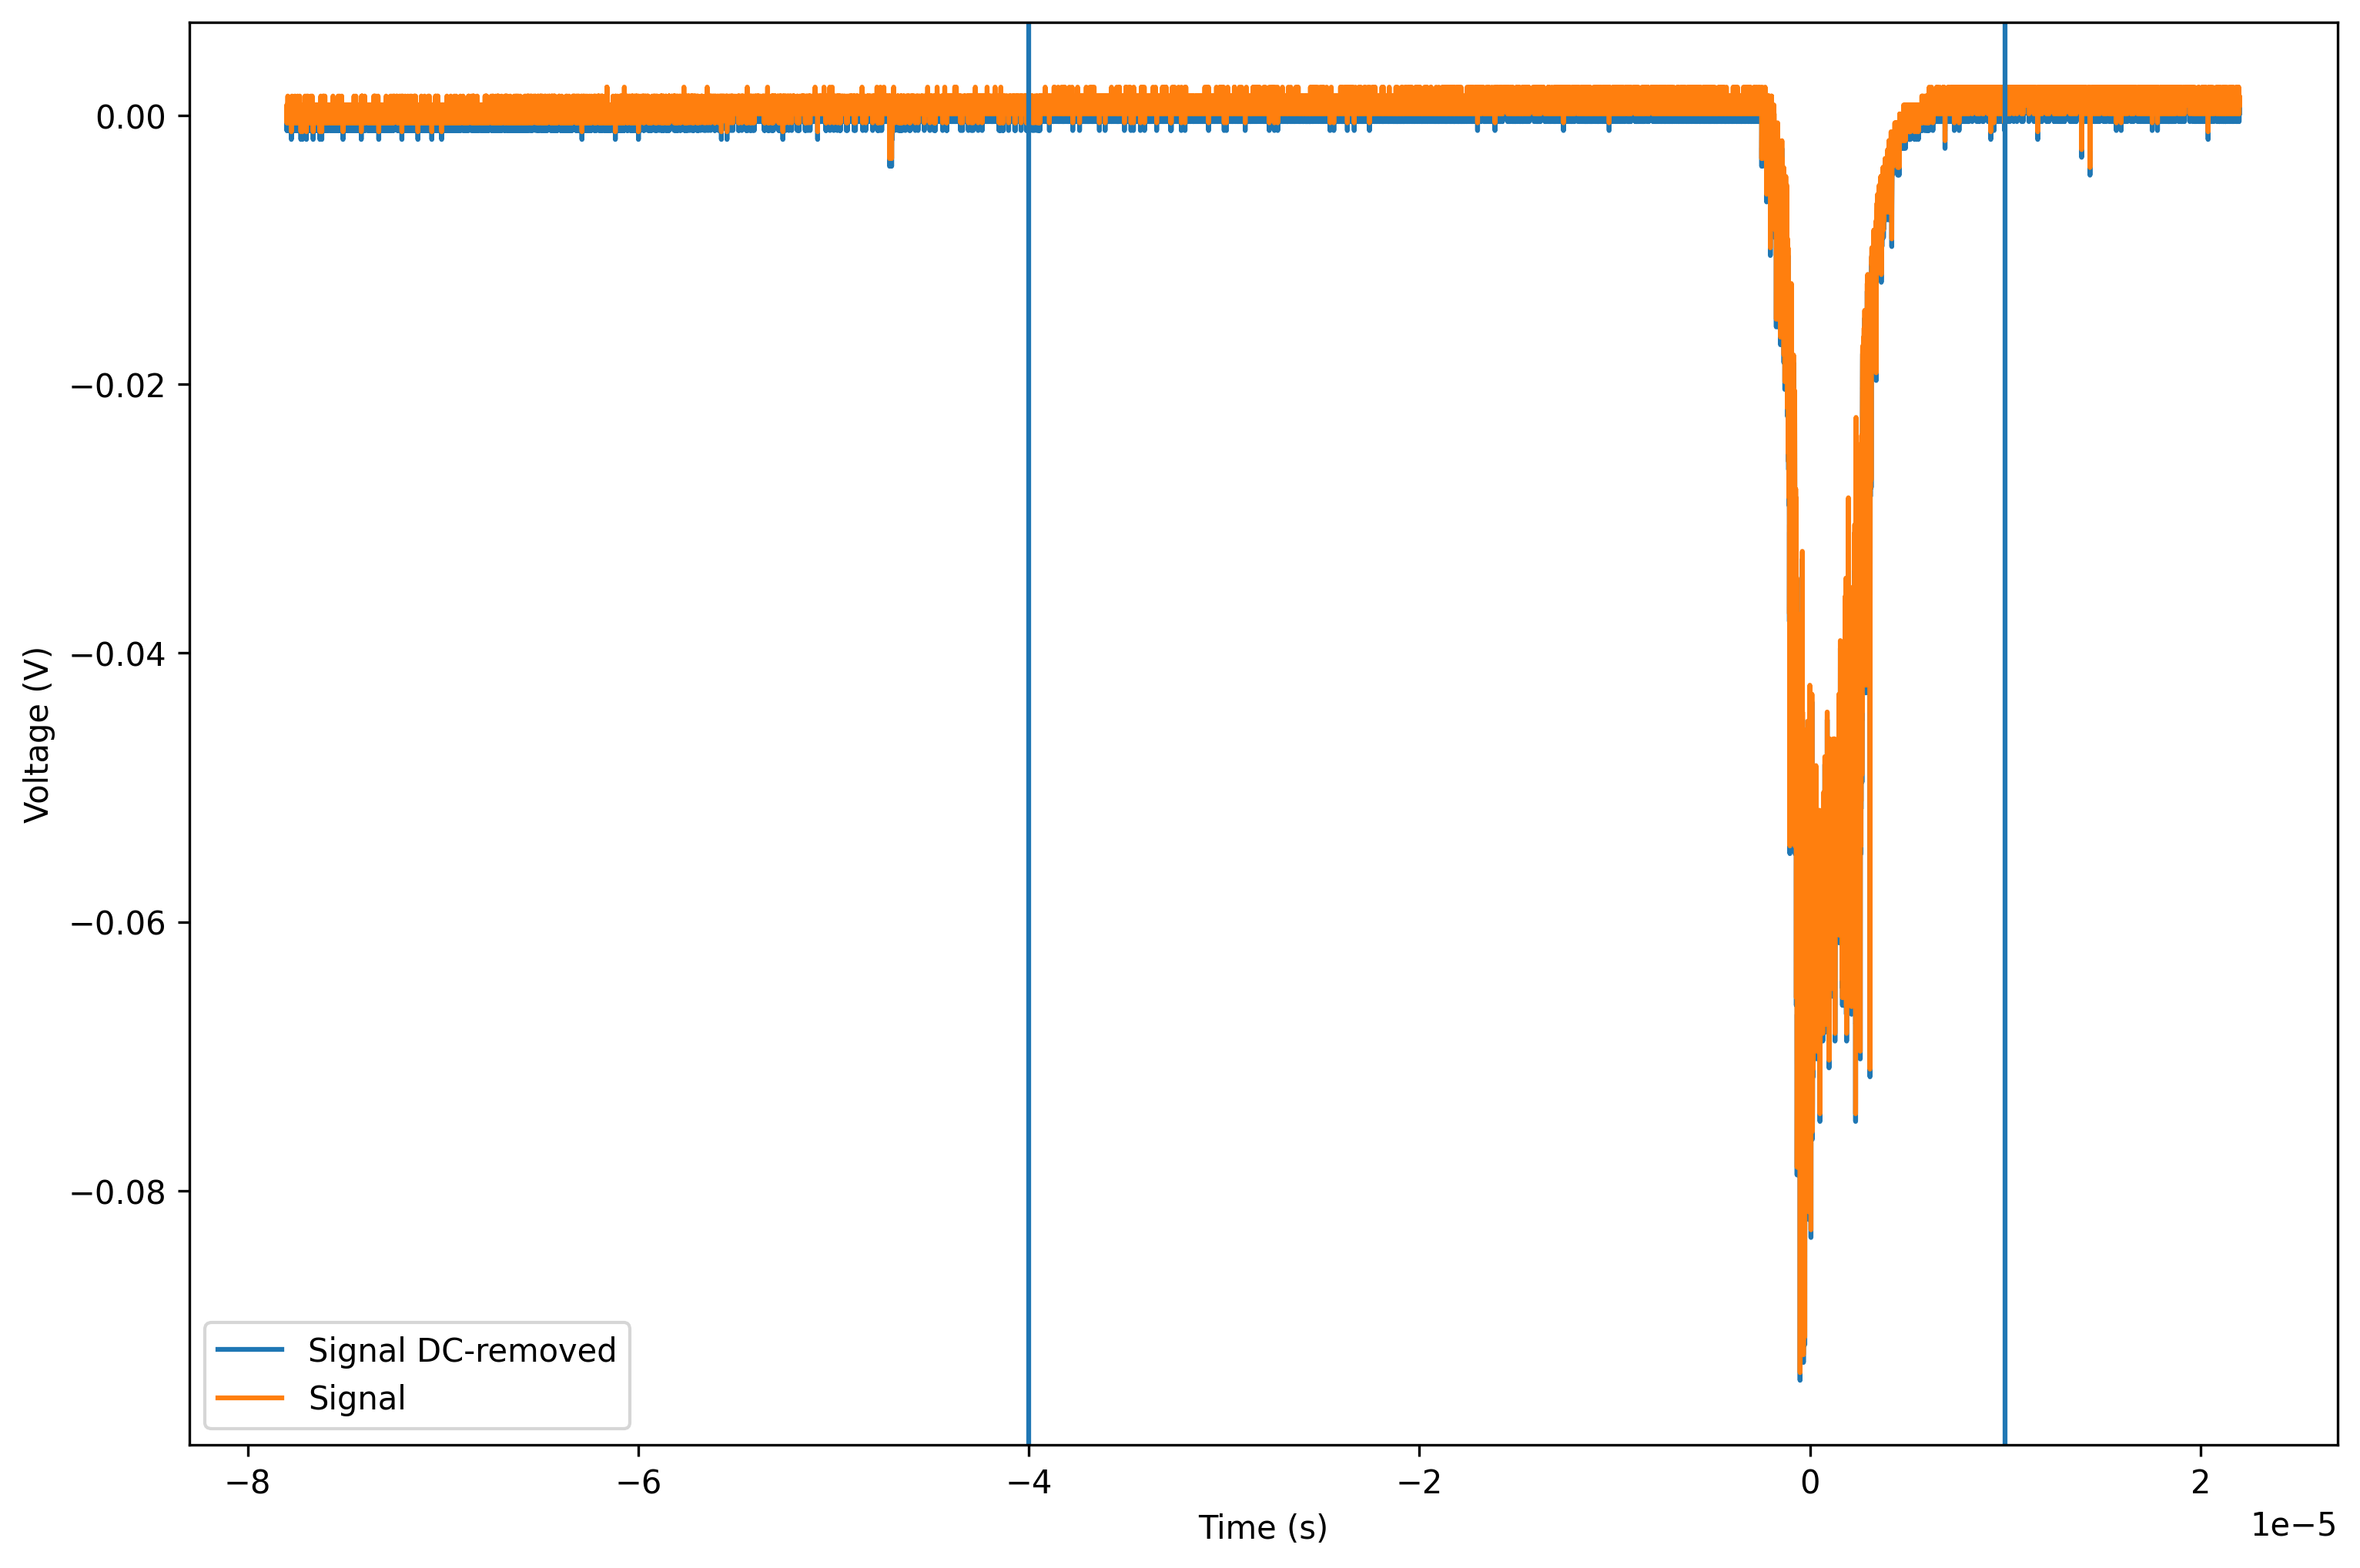

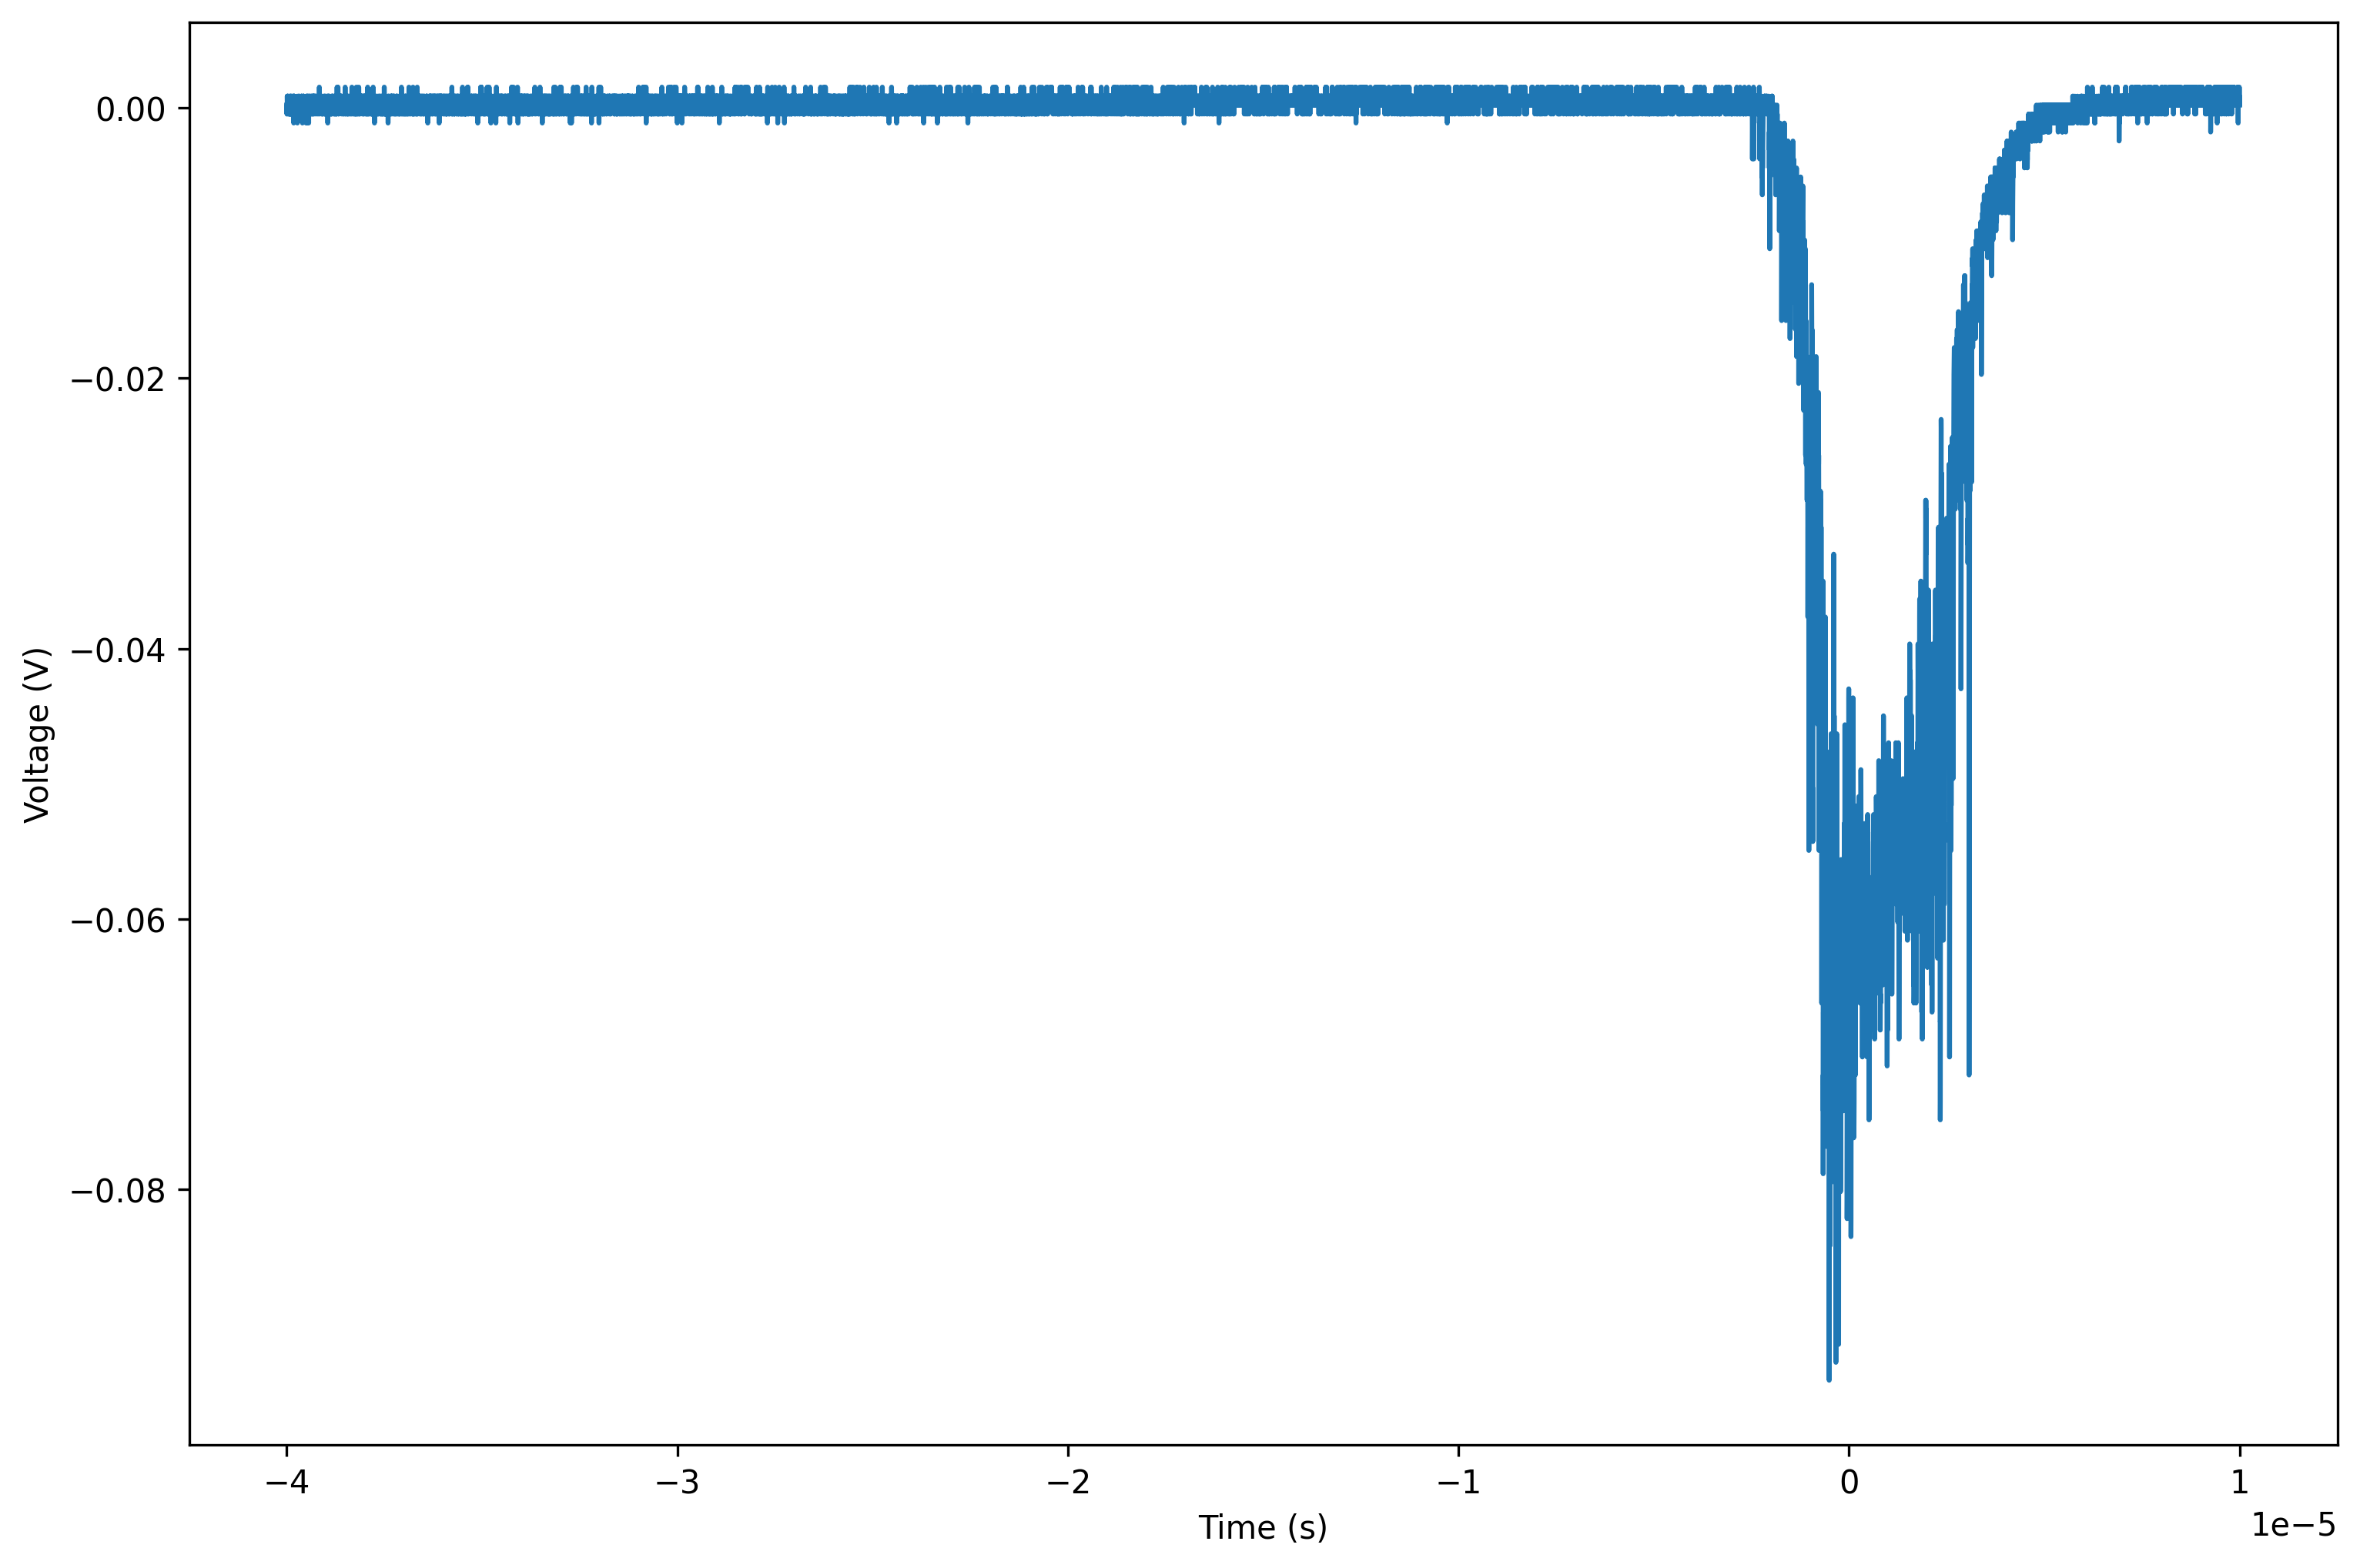

(2.1024830033321148e-07, 10382.63211522032)

In [16]:
getArea(Run2QuickCh1[14],-4e-5,1e-5,minpulse=-0.003,gain=DrBrandtGains[0],p=True)


In [17]:
if(not(os.path.exists(Path+"Run1_Ch1_S2data.p"))): 
    Run1_Ch1data=getValues(Run1_Ch1,5,single=False,prnt=False)
    PickleITDump(Run1_Ch1data,Path+"Run1_Ch1_S2data.p")
else:
    Run1_Ch1data=PickleITRead(Path+"Run1_Ch1_S2data.p")
    
if(not(os.path.exists(Path+"Run1_Ch2_S2data.p"))):
    Run1_Ch2data=getValues(Run1_Ch2,5,single=False,prnt=False)
    PickleITDump(Run1_Ch2data,Path+"Run1_Ch2_S2data.p")
else:
    Run1_Ch2data=PickleITRead(Path+"Run1_Ch2_S2data.p")

In [20]:
################### Run1 Comp ########################
#### Ch1 ####
Run1_Ch1AreaPEIlker=MultiAreaPE(Run1_Ch1data,-4e-5,1e-5,minpulse=9999,g=IlkersGains[0],p=False)
Run1_Ch1AreaPENick=MultiAreaPE(Run1_Ch1data,-4e-5,1e-5,minpulse=9999,g=NicksGains[0],p=False)
Run1_Ch1AreaPEDrBrantdsLab=MultiAreaPE(Run1_Ch1data,-4e-5,1e-5,minpulse=9999,g=DrBrandtGains[0],p=False)
#### Ch2 ####

Run1_Ch2AreaPEIlker=MultiAreaPE(Run1_Ch2data,-4e-5,1e-5,minpulse=9999,g=IlkersGains[0],p=False)
Run1_Ch2AreaPENick=MultiAreaPE(Run1_Ch2data,-4e-5,1e-5,minpulse=9999,g=NicksGains[0],p=False)
Run1_Ch2AreaPEDrBrantdsLab=MultiAreaPE(Run1_Ch2data,-4e-5,1e-5,minpulse=9999,g=DrBrandtGains[0],p=False)



'''values={"Day2_Ch1Area_PMT1":MultiAreaPE(Ch1data,-4e-5,1e-5,minpulse=9999,g=1,p=False)[0],
        "Day2_Ch2Area_PMT3":MultiAreaPE(Ch2data,-4e-5,1e-5,minpulse=9999,g=1,p=False)[0],
        "Day1_Ch1Area_PMT1":MultiAreaPE(Run1_Ch1data,-4e-5,1e-5,minpulse=9999,g=1,p=False)[0],
        "Day1_Ch2Area_PMT3":MultiAreaPE(Run1_Ch2data,-4e-5,1e-5,minpulse=9999,g=1,p=False)[0]}
PickleITDump(values,"Area.p")'''

'values={"Day2_Ch1Area_PMT1":MultiAreaPE(Ch1data,-4e-5,1e-5,minpulse=9999,g=1,p=False)[0],\n        "Day2_Ch2Area_PMT3":MultiAreaPE(Ch2data,-4e-5,1e-5,minpulse=9999,g=1,p=False)[0],\n        "Day1_Ch1Area_PMT1":MultiAreaPE(Run1_Ch1data,-4e-5,1e-5,minpulse=9999,g=1,p=False)[0],\n        "Day1_Ch2Area_PMT3":MultiAreaPE(Run1_Ch2data,-4e-5,1e-5,minpulse=9999,g=1,p=False)[0]}\nPickleITDump(values,"Area.p")'

In [21]:

##### 150 us Simulation
_015ms_Files = glob.glob("/media/ilker/Ilker/CRAB/Simulation/simdata/02ms/counts/*.txt",recursive=True)
_015ms_values=getSimValues(_015ms_Files,1)


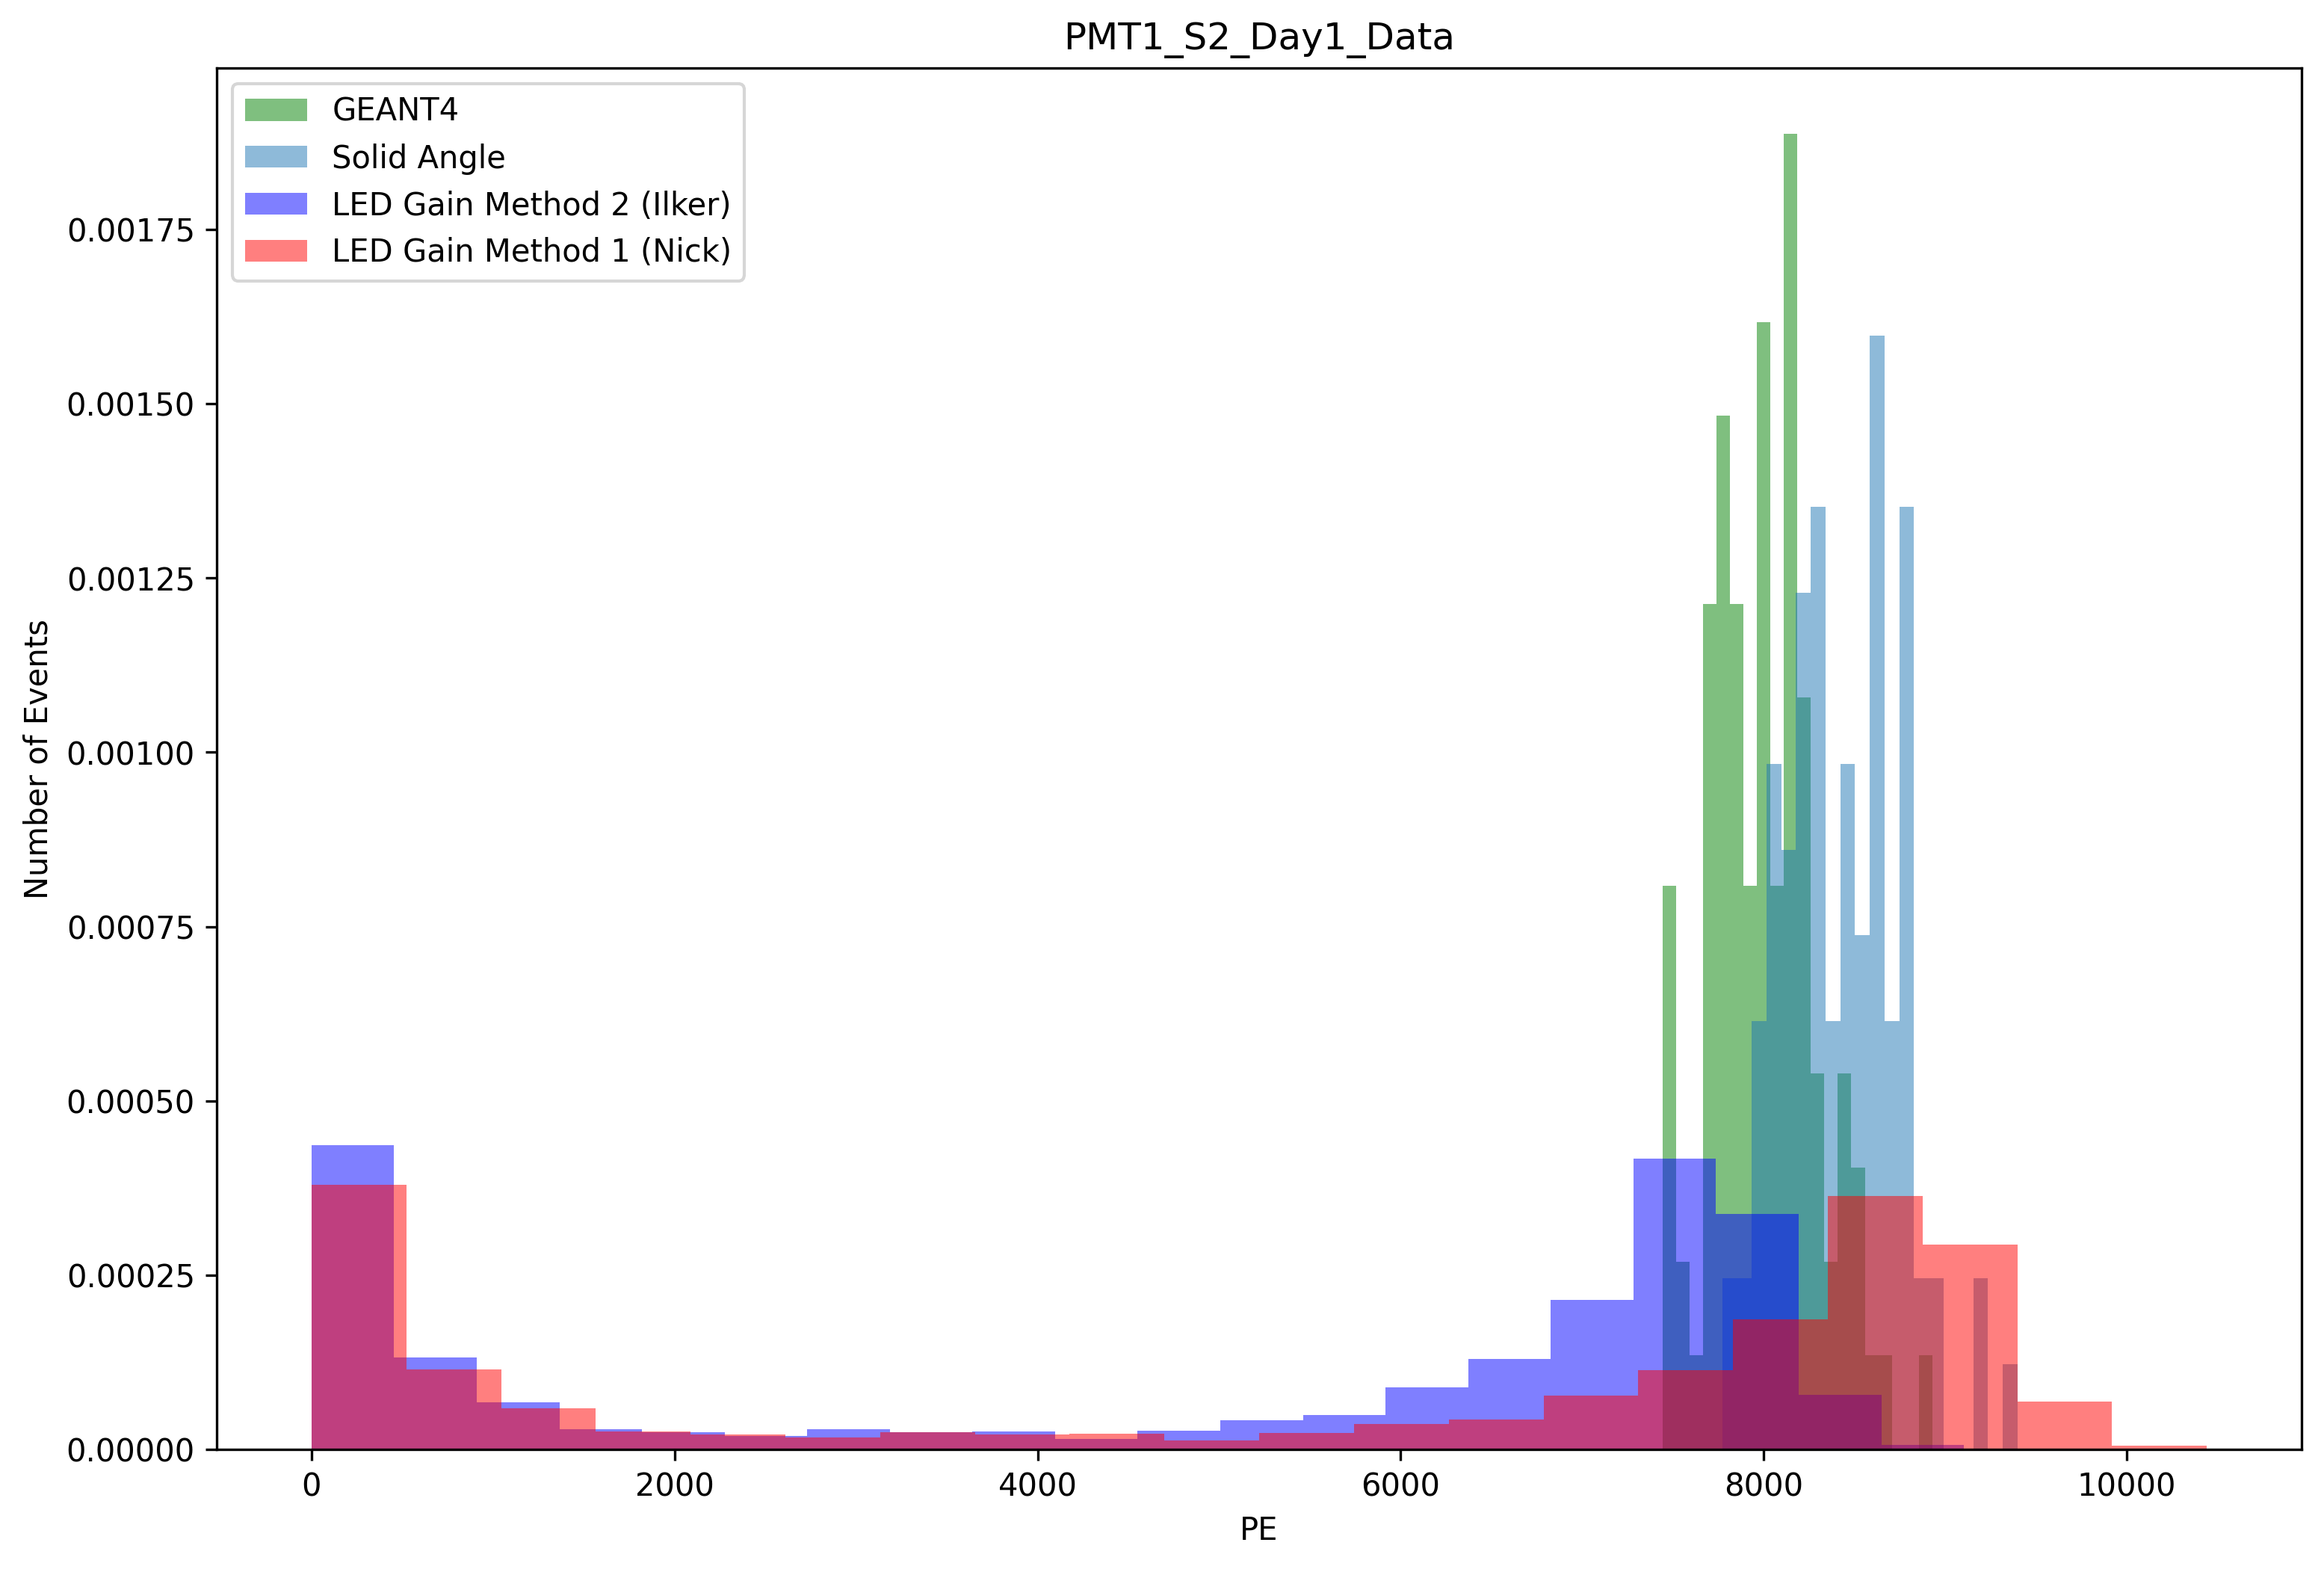

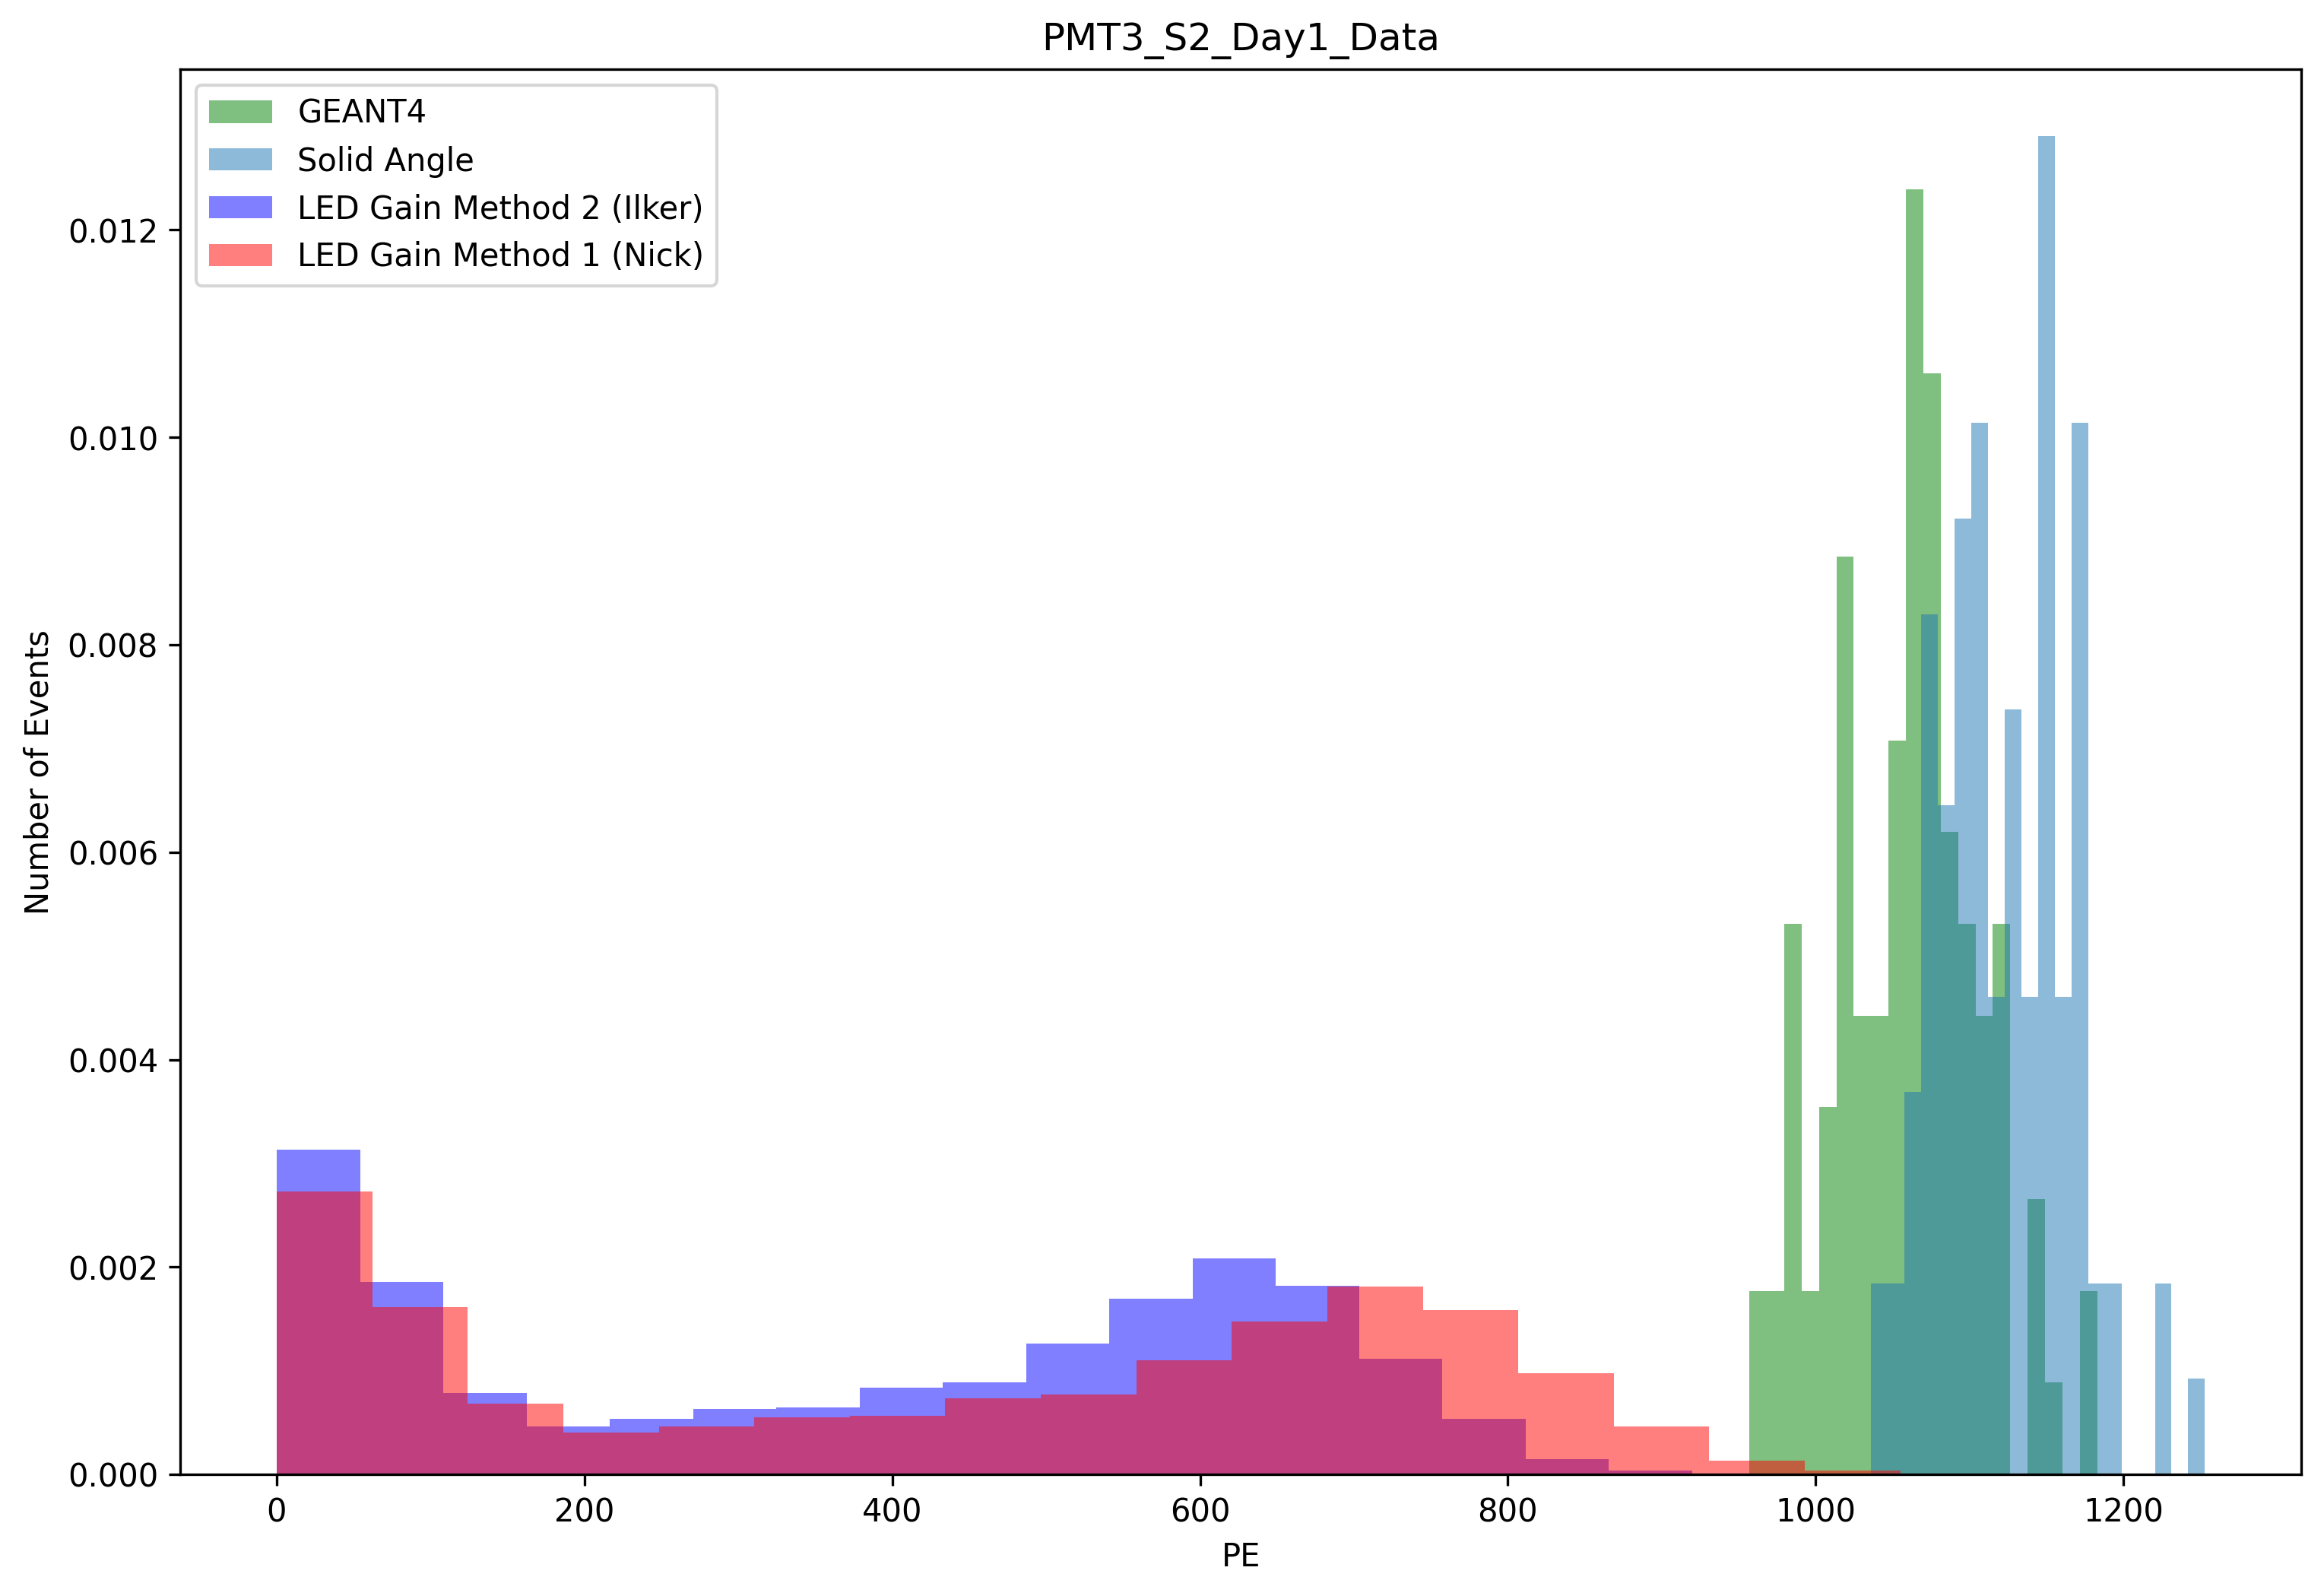

In [23]:
#### PMT1 ########
plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT1_S2_Day1_Data")
plt.ylabel("Number of Events")
plt.xlabel("PE")

plt.hist(S2_PMT1,bins=binss,density=True,stacked=True,label="GEANT4",color="g",alpha=0.5)
plt.hist(S2_PMT1_Solid,bins=binss,density=True,stacked=True,label="Solid Angle",alpha=0.5)

plt.hist(Run1_Ch1AreaPEIlker[1],bins=binss,density=True,stacked=True,label="LED Gain Method 2 (Ilker)",color="b",alpha=0.5)
plt.hist(Run1_Ch1AreaPENick[1],bins=binss,density=True,stacked=True,label="LED Gain Method 1 (Nick)",color="r",alpha=0.5)
#plt.hist(S2["S2_PHOTOCATHODE"],bins=binss,density=True,stacked=True,label="GEANT4 S2_Sim",color="g")

#plt.hist(S2_Detailed["S2_PHOTOCATHODE"]["Pb210"],bins=binss ,density=True,stacked=True,label="Pb210(beta_[15keV or 61.5keV])_GEANT4",alpha=0.5)
#plt.hist(S2_Detailed["S2_PHOTOCATHODE"]["Bi210"],bins=binss ,density=True,stacked=True,label="Bi210(beta_[1.161MeV])_GEANT4",alpha=0.5)
#plt.hist(S2_Detailed["S2_PHOTOCATHODE"]["Bi210[46.539]"],bins=binss ,density=True,stacked=True,label="Bi210(gamma_[46.539keV])_GEANT4",alpha=0.5)
#plt.hist(S2_Detailed["S2_PHOTOCATHODE"]["Po210"],bins=binss ,color="b",density=True,stacked=True,label="Pb210(Alpha_[5.3 MeV])_GEANT4",alpha=0.5)
#plt.hist(Run1_Ch1AreaPEDrBrantdsLab[1],bins=50,density=True,stacked=True,label="Gain From Dr Brandts lab",color="y")
#plt.semilogy()

#plt.hist(_015ms_values["S2_PHOTOCATHODE"],bins=50 ,density=True,stacked=True,label="200 us GEANT4",color="g")


plt.legend()
plt.show()
#plt.semilogy()
#mean=st.mean(Ch1AreaPE[1])
#stdev=st.stdev(Ch1AreaPE[1])

#print(f"DATA PE mean = {mean} stdev = {stdev}")
#print(f"SIM PE mean = {PMT1_S2_mean} stdev = {PMT1_S2_stdev}")


#### PMT3 ###########

plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT3_S2_Day1_Data")
plt.ylabel("Number of Events")
plt.xlabel("PE")
#plt.hist(S2["S1_PHOTOCATHODE"],bins=binss,density=True,stacked=True,label="GEANT4 S2_Sim",color="g")
#plt.hist(Run1_Ch2AreaPEIlker[1],bins=50,density=True,stacked=True,label="Ilker's Gain",color="b")
plt.hist(S2_PMT3,bins=binss ,density=True,stacked=True,label="GEANT4",color="g",alpha=0.5)
plt.hist(S2_PMT3_Solid,bins=binss ,density=True,stacked=True,label="Solid Angle",alpha=0.5)
plt.hist(Run1_Ch2AreaPEIlker[1],bins=binss,density=True,stacked=True,label="LED Gain Method 2 (Ilker)",color="b",alpha=0.5)
plt.hist(Run1_Ch2AreaPENick[1],bins=binss,density=True,stacked=True,label="LED Gain Method 1 (Nick)",color="r",alpha=0.5)
#plt.hist(Run1_Ch2AreaPEDrBrantdsLab[1],bins=50,density=True,stacked=True,label="Gain From Dr Brandts lab",color="y")
#plt.hist(_015ms_values["S1_PHOTOCATHODE"],bins=50 ,density=True,stacked=True,label="200 us GEANT4",color="g")
#plt.hist(S2_Detailed["S1_PHOTOCATHODE"]["Pb210"],bins=binss ,density=True,stacked=True,label="Pb210(beta_[15keV or 61.5keV])_GEANT4",alpha=0.5)
#plt.hist(S2_Detailed["S1_PHOTOCATHODE"]["Bi210"],bins=binss ,density=True,stacked=True,label="Bi210(beta_[1.161MeV])_GEANT4",alpha=0.5)
#plt.hist(S2_Detailed["S1_PHOTOCATHODE"]["Bi210[46.539]"],bins=binss ,density=True,stacked=True,label="Bi210(gamma_[46.539keV])_GEANT4",alpha=0.5)
#plt.hist(S2_Detailed["S1_PHOTOCATHODE"]["Po210"],bins=binss ,density=True,stacked=True,label="Pb210(Alpha_[5.3 MeV])_GEANT4",color="b",alpha=0.5)
plt.legend()
plt.show()
#plt.semilogy()
#mean=st.mean(Ch1AreaPE[1])
#stdev=st.stdev(Ch1AreaPE[1])

#print(f"DATA PE mean = {mean} stdev = {stdev}")
#print(f"SIM PE mean = {PMT1_S2_mean} stdev = {PMT1_S2_stdev}")


In [ ]:
#Run1_Ch1AreaPE=MultiAreaPE(Run1_Ch1data,-4e-5,1e-5,minpulse=9999,g=DrBrandtGains[0],p=False)
#Run1_Ch2AreaPE=MultiAreaPE(Run1_Ch2data,-4e-5,1e-5,minpulse=9999,g=DrBrandtGains[0],p=False)


In [ ]:
'''plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT1")
plt.ylabel("Number of Events")
plt.xlabel("PE")
#plt.hist(S2["S2_PHOTOCATHODE"],bins=100,density=True,stacked=True,label="S2_Sim",color="g")
plt.hist(Run1_Ch1AreaPE[1],bins=100,density=True,stacked=True,label="S2_Day1_Data",color="b")
plt.legend()
plt.show()
#plt.semilogy()
mean=st.mean(Run1_Ch1AreaPE[1])
stdev=st.stdev(Run1_Ch1AreaPE[1])
print(f"Area mean = {mean} stdev = {stdev}")
'''

In [ ]:
'''plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT3")
plt.ylabel("Number of Events")
plt.xlabel("PE")
#plt.hist(S2["S1_PHOTOCATHODE"],bins=100,density=True,stacked=True,label="S2_Sim",color="g")
plt.hist(Run1_Ch2AreaPE[1],bins=100,density=True,stacked=True,label="S2_Day1_Data",color="b")
plt.legend()
plt.show()
#plt.semilogy()
mean=st.mean(Run1_Ch2AreaPE[1])
stdev=st.stdev(Run1_Ch2AreaPE[1])
print(f"Area mean = {mean} stdev = {stdev}")
'''